In [2]:
# Imports

#Dwave imports
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dimod
from __future__ import print_function

import dimod
import math
import sys
import copy

from dimod.generators.constraints import combinations

from hybrid.reference import KerberosSampler

#Impots for QUBO problem
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib as plt
import itertools as it
from itertools import product
from matplotlib import pyplot as plt
import math

import matplotlib.pyplot as plt
import networkx as nx

In [3]:
#Dwave imports
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dimod

#Impots for QUBO probelm
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib as plt
import itertools
from itertools import product
from matplotlib import pyplot as plt
import math


In [4]:
def make_img_bit_string(b):
    plt.imshow(b.reshape((n,n)))
    plt.show()
    print(b)

Generate all of the possible lines from cart coords, currently doesnt encode vertical lines. And the QUBO matrix. There are two version of the QUBO matrix, the first penalises acceptable skew lines and the latter is a minor improvment. Details in the notebook.

In [3]:
#Find all fo the lines to optimise over
def get_skew_lines(n):
    #Get list of cart coords
    xs = np.linspace(0,n,n,endpoint = False)
    ys = np.linspace(0,n,n,endpoint = False)
    X = product(xs,ys)
    X = np.array(list(X))
    #dx,dy,y_intercept

    lines = []
    for k in range(X.shape[0]):
        for d in range(k,X.shape[0]):
            if X[k][0]-X[d][0] != 0 and X[k][1]-X[d][1] != 0:
                grad = (X[k][1]-X[d][1])/(X[k][0]-X[d][0])
                y_intercept = X[k][1] - grad * X[k][0]
                line = (grad,y_intercept)
                lines.append(line)
    lines = np.array(lines)
    return lines

#Check if a point is on a line (l belongs to delta_l)
def delta_l(i,j,a,b,n):
    if np.round(j - a*i - b, 1) == 0 and i < n and j < n:
        return True
    else: 
        return False


def get_Q(n,lines,alpha,beta,gamma,omega):
    Q = np.zeros((n**2,n**2))
    rows = np.linspace(0,n,n,endpoint = False, dtype = 'int32')
    cols = np.linspace(0,n,n,endpoint = False, dtype = 'int32')

#1
    for i in cols:
        for j in rows:
            for s in rows:
                Q[int(i*n+j),int(i*n+s)] += alpha
#2
    for j in rows:
        for i in cols:
            for r in cols:
                Q[int(i*n+j),int(r*n+j)] += beta
#3
    for l in lines:
        a = l[0]
        b = l[1]
        for i in cols:
            for j in rows:
                for r in cols:
                    for s in rows:
                        if delta_l(i,j,a,b,n) & delta_l(r,s,a,b,n):
                            Q[int(i*n+j),int(r*n+s)] += gamma
#4
    for i in rows:
        for j in cols:
            Q[int(i*n+j),int(i*n+j)] -=4*(alpha + beta)
#5
    for l in lines:
        a = l[0]
        b = l[1]
        for i in cols:
            for j in rows:
                if delta_l(i,j,a,b,n):
                    Q[int(i*n+j),int(i*n+j)] -= 4*gamma
#6
    for i in cols:
        for j in rows:
            Q[int(i*n+j),int(i*n+j)] -= 4 * n
            for r in cols:
                for s in rows:
                    Q[int(i*n+j),int(r*n+s)] += omega
    return Q



def get_Q_rev(n,lines,alpha,beta,gamma,omega):

    Q = np.zeros((n**2,n**2))
    rows = np.linspace(0,n,n,endpoint = False, dtype = 'int32')
    cols = np.linspace(0,n,n,endpoint = False, dtype = 'int32')


    #Vertical lines
    for i in cols:
        for j in rows:
            Q[i*n+j,i*n+j] -= 4*alpha
            for s in rows:
                Q[i*n+j,i*n+s] += alpha

    
    #Horizontal lines:
    for j in rows:
        for i in cols:
            Q[i*n+j,i*n+j] -= 4*beta
            for r in cols:
                Q[i*n+j,r*n+j] += beta

    #Skew lines
    for l in lines:
        a = l[0]
        b = l[1]
        for i in cols:
            for i in rows:
                if delta_l(i,j,a,b,n):
                    Q[i*n+j,i*n+j] -= 7*gamma
                for r in cols:
                    for s in rows:
                        if delta_l(i,j,a,b,n) and delta_l(r,s,a,b,n):
                            Q[i*n+j,r*n+s] += 3 * gamma
    return Q






In [4]:
def nthreeingline_4(n):
    bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)

    bqm.update(combinations([f's_{i}_{j}' for i in range(n) for j in range(n)],20,strength = 1))

    lines = get_skew_lines(n)
    
    for (a,b) in lines:
        valid_i_j = []
        for i in range(n):
            for j in range(n):
                if delta_l(i,j,a,b,n):
                    valid_i_j.append((i,j))
        bqm.add_linear_inequality_constraint([(f's_{i}_{j}',1) for (i,j) in valid_i_j],10,lb = 0,ub=2,label = 'slack')

    for j in range(n):
        bqm.add_linear_inequality_constraint([(f's_{i}_{j}',1) for i in range(n)],10,lb = 0,ub=2,label = 'slack')

    for i in range(n):
        bqm.add_linear_inequality_constraint([(f's_{i}_{j}',1) for j in range(n)],10,lb = 0,ub=2,label = 'slack')
    return bqm

solution = KerberosSampler().sample(nthreeingline_4(8), num_reads = 1)



/usr/local/lib/python3.9/site-packages/dimod/binary/binary_quadratic_model.py:764: UserWarning: Did not add constraint slack. This constraint is feasible with any value for state variables.
  warnings.warn(


In [16]:
df = solution.to_pandas_dataframe()

In [17]:
df

,s_0_0,s_0_1,s_0_2,s_0_3,s_0_4,s_0_5,s_0_6,s_0_7,s_1_0,s_1_1,...,s_7_2,s_7_3,s_7_4,s_7_5,s_7_6,s_7_7,slack_slack_0,slack_slack_1,energy,num_occurrences
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,400.0,1


In [18]:
n = 8

In [19]:
make_img_bit_string(df.values[:-4])

ValueError: cannot reshape array of size 0 into shape (8,8)

The above function generates the QUBO matrix, details in my notebook.

In [20]:
n = 5

In [21]:
def get_lowest_eval(Q):
    w,v = LA.eig(Q)
    g = v[np.argmin(w)]
    print('The lowest energy is' , w[np.argmin(w)])
    return g

In [ ]:
def get_bin_list(n):
    bin_list = np.array(list(map(list, itertools.product([0, 1], repeat=n**2))))[1:]
    return bin_list

bin_list = get_bin_list(n)

In [ ]:
bin_list.shape

In [ ]:
np.savetxt('binary_string',bin_list,delimiter = ',') #run later

In [ ]:
def get_lowest_bitstring(bin_list,Q):
    energies = []
    for i in range(bin_list.shape[0]):
        E = bin_list[i].T @ Q @ bin_list[i]
        energies.append(E)
    b = bin_list[np.argmin(energies)]
    print('The lowest energy is' , energies[np.argmin(energies)])
    return b,energies

In [ ]:

lines = np.unique(get_skew_lines(n),axis = 0)
Q_1 = get_Q(n,lines,1,1,1,1)
Q_1_rev= get_Q_rev(n,lines,1,1,1,1)

Q_2 = get_Q(n,lines,2,2,1,1)
Q_2_rev = get_Q_rev(n,lines,2,2,1,1)

Q_3 = get_Q(n,lines,1,1,5,1)
Q_3_rev = get_Q_rev(n,lines,1,1,5,1)


In [ ]:
ground_string_1,energies_1 = get_lowest_bitstring(bin_list,Q_1)
ground_string_1_rev,energies_1_rev = get_lowest_bitstring(bin_list,Q_1_rev)
make_img_bit_string(ground_string_1)
make_img_bit_string(ground_string_1_rev)


In [ ]:
ground_string_2,energies_2 = get_lowest_bitstring(bin_list,Q_2)
ground_string_2_rev,energies_2_rev = get_lowest_bitstring(bin_list,Q_2_rev)
make_img_bit_string(ground_string_2)
make_img_bit_string(ground_string_2_rev)

In [ ]:
ground_string_3,energies_3 = get_lowest_bitstring(bin_list,Q_3)
ground_string_3_rev,energies_3_rev = get_lowest_bitstring(bin_list,Q_3_rev)
make_img_bit_string(ground_string_3)
make_img_bit_string(ground_string_3_rev)

Dwave quantum annealer, set inderactions to be the off-diagonal elements of the QUBO matrix Q. Set the diagonal elements to be the activation weights.

In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

n = 5

#define binary decision vector.
x = [f's_{i}' for i in range(n**2)]

bqm = BinaryQuadraticModel('BINARY')

for d in range(n**2):
    bqm.add_variable(x[int(d)],Q[int(d),int(d)])
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        if i != j:
            bqm.add_interaction(x[int(i)],x[int(j)],Q[i,j])


sols = []
for i in range(10):
    sampler = EmbeddingComposite(DWaveSampler())
    sampletest = sampler.sample(bqm, num_reads = 5000)
    solution = np.array(list(sampletest.first.sample.values()))
    energy = sampletest.first.energy
    sols.append((solution,energy))
    make_img_bit_string(solution)

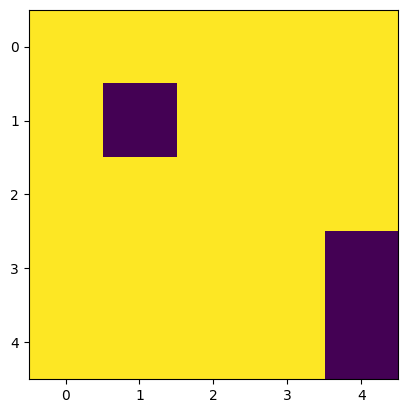

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]


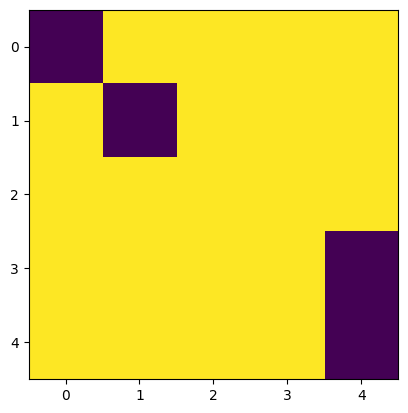

[0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]


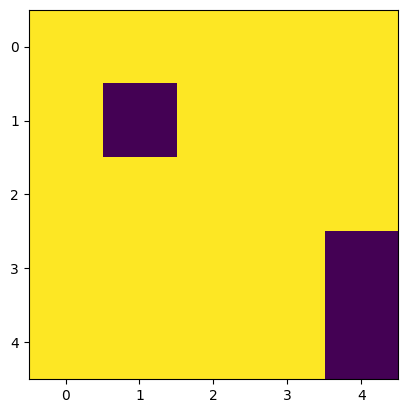

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]


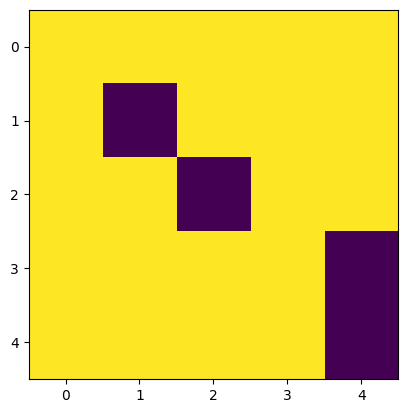

[1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0]


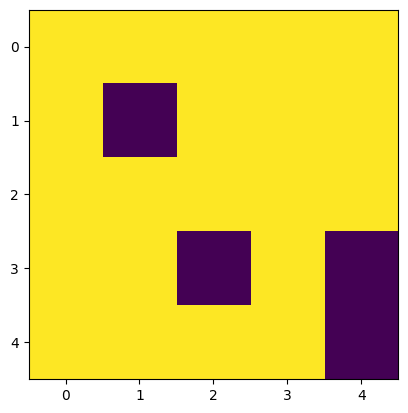

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0]


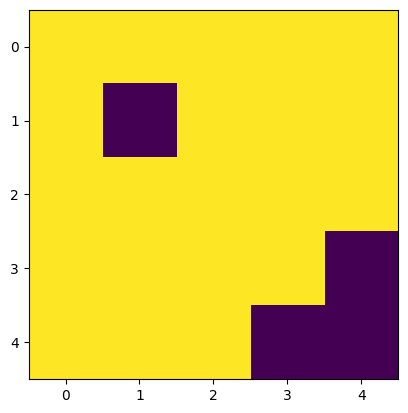

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0]


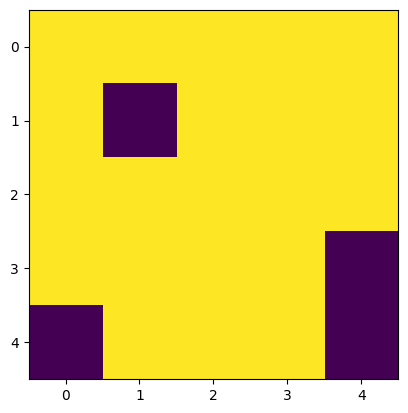

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]


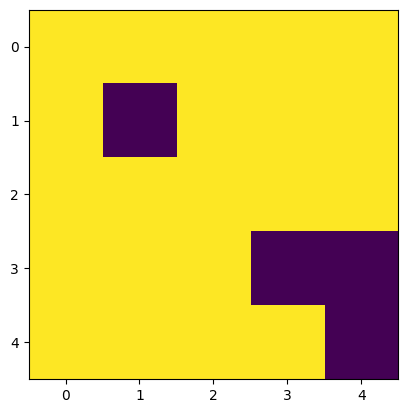

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0]


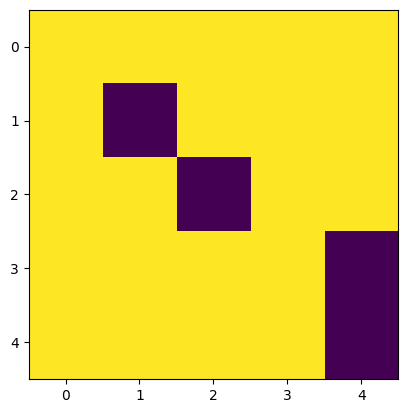

[1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0]


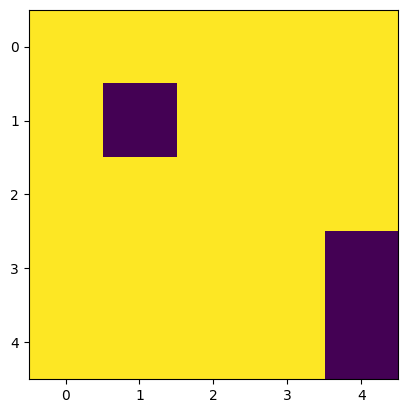

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]


In [9]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

n = 5
lines = np.unique(get_skew_lines(n),axis = 0)

Q = get_Q_rev(n,lines,-1,-1,-1,1)
#define binary decision vector.
x = [f's_{i}' for i in range(n**2)]

bqm = BinaryQuadraticModel('BINARY')

for d in range(n**2):
    bqm.add_variable(x[int(d)],Q[int(d),int(d)])
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        if i != j:
            bqm.add_interaction(x[int(i)],x[int(j)],Q[i,j])

sols = []
for i in range(10):
    sampler = EmbeddingComposite(DWaveSampler())
    sampletest = sampler.sample(bqm, num_reads = 5000)
    solution = np.array(list(sampletest.first.sample.values()))
    energy = sampletest.first.energy
    sols.append((solution,energy))
    make_img_bit_string(solution)

In [ ]:
make_img_bit_string(solution)

# Discrete binary model encoding

In [ ]:
#Linear only

In [15]:
def make_img_dis(b):
    s = np.zeros((n,n))
    for i in range(n):
            s[i,b[i]] = 1
            s[i,b[i+n]] = 1 

    plt.imshow(s)
    plt.show()

In [16]:
#Usfull spaces:
n = 3

N_3 = [perm for perm in itertools.permutations(range(n),3)]
N3 = [prod for prod in itertools.product(range(n), repeat =  3)]
N6 = [prod for prod in itertools.product(range(n), repeat =  6)]
N_6 = [perm for perm in itertools.permutations(range(n),6)]
B = [binary for binary in itertools.product([0, 1], repeat = 3)]
N2 = [prod for prod in itertools.product(range(n), repeat = 2)]


In [4]:
## Linear attempt
def get_linear(n):
    X_lin = np.zeros((2*n,n))
    for i,j,k in N_3:
        for s,r,t in B:
            for u1,u2,u3 in N_3:
                if i > j and j > k:
                    X_lin[k + n*t,u1] -= (j - i)*u1
                    X_lin[j + r*n,u2] -= (i - k)*u2
                    X_lin[i + s*n,u3] -= (k - j)*u3
    return X_lin

In [5]:
#Add costs
dqm = dimod.DiscreteQuadraticModel()
dis_vars = []
X_lin = get_linear(n)
for i in range(2*n):
    dis_vars.append(dqm.add_variable(n))
    for case in range(n):
        dqm.set_linear_case(dis_vars[i],case,X_lin[i,case])

from dwave.system import LeapHybridDQMSampler
dqm_sampler = LeapHybridDQMSampler()
sampleset = dqm_sampler.sample_dqm(dqm) 

df =  sampleset.to_pandas_dataframe().drop_duplicates()
df 

,0,1,2,3,4,5,energy,num_occurrences
0,0,2,0,0,2,0,-64.0,1
14,1,2,0,1,0,0,-16.0,1
15,1,2,1,0,1,0,-32.0,1
16,0,1,1,0,2,0,-40.0,1
17,2,2,0,0,2,0,-48.0,1
18,0,1,0,0,2,0,-48.0,1
19,1,2,0,0,2,0,-56.0,1
20,0,2,0,0,0,1,-24.0,1
21,1,2,0,0,1,1,-32.0,1
22,2,2,0,2,2,2,-16.0,1


In [ ]:
for i in range(df.shape[0]):
    make_img_dis(np.array(df.iloc[i,:2*n],dtype = 'int32'))
    print(df.iloc[i,:2*n+1])

In [91]:
#Usfull spaces:
n = 5

N_3 = [perm for perm in itertools.permutations(range(n),3)]
N3 = [prod for prod in itertools.product(range(n), repeat =  3)]
N6 = [prod for prod in itertools.product(range(n), repeat =  6)]
N_6 = [perm for perm in itertools.permutations(range(n),6)]
B = [binary for binary in itertools.product([0, 1], repeat = 3)]
N2 = [prod for prod in itertools.product(range(n), repeat = 2)]

In [92]:
#Add costs
dqm = dimod.DiscreteQuadraticModel()
dis_vars = []
X_lin = get_linear(n)
for i in range(2*n):
    dis_vars.append(dqm.add_variable(n))
    for case in range(n):
        dqm.set_linear_case(dis_vars[i],case,X_lin[i,case])

from dwave.system import LeapHybridDQMSampler
dqm_sampler = LeapHybridDQMSampler()
sampleset = dqm_sampler.sample_dqm(dqm) 
df_5 =  sampleset.to_pandas_dataframe().drop_duplicates()
df_5 

,0,1,2,3,4,5,6,7,8,9,energy,num_occurrences
0,0,2,3,3,4,1,2,3,3,0,-1952.0,1
1,1,2,3,3,0,1,2,3,3,3,-1952.0,1
2,1,2,3,3,3,0,2,3,3,3,-1952.0,1
3,1,2,3,3,0,0,2,3,3,3,-1952.0,1
4,0,2,3,3,0,1,2,3,3,0,-1952.0,1
5,1,2,3,3,0,0,2,3,3,0,-1952.0,1
6,1,2,3,3,3,1,2,3,3,0,-1952.0,1
7,0,2,3,3,0,0,2,3,3,3,-1952.0,1
8,0,2,3,3,3,1,2,3,3,4,-1952.0,1
9,1,2,3,3,4,0,2,3,3,4,-1952.0,1


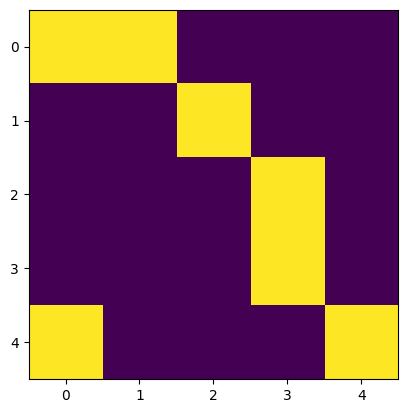

0            0.0
1            2.0
2            3.0
3            3.0
4            4.0
5            1.0
6            2.0
7            3.0
8            3.0
9            0.0
energy   -1952.0
Name: 0, dtype: float64


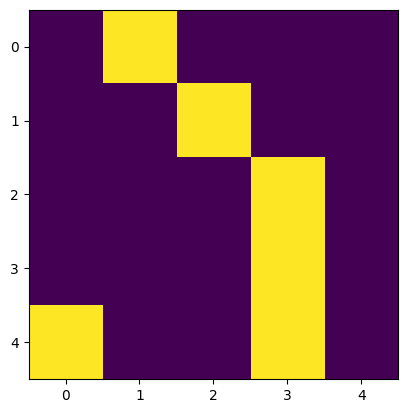

0            1.0
1            2.0
2            3.0
3            3.0
4            0.0
5            1.0
6            2.0
7            3.0
8            3.0
9            3.0
energy   -1952.0
Name: 1, dtype: float64


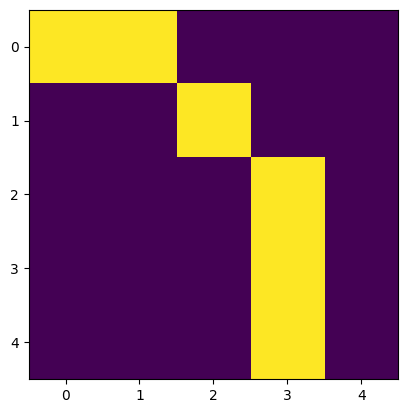

0            1.0
1            2.0
2            3.0
3            3.0
4            3.0
5            0.0
6            2.0
7            3.0
8            3.0
9            3.0
energy   -1952.0
Name: 2, dtype: float64


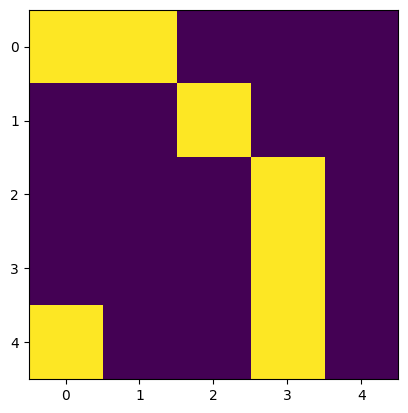

0            1.0
1            2.0
2            3.0
3            3.0
4            0.0
5            0.0
6            2.0
7            3.0
8            3.0
9            3.0
energy   -1952.0
Name: 3, dtype: float64


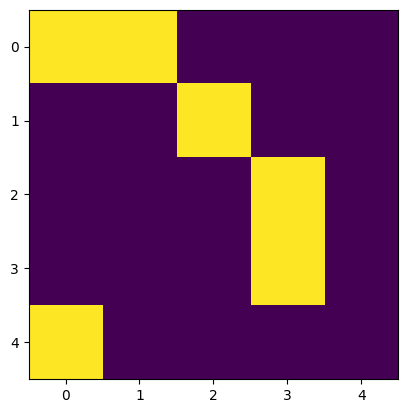

0            0.0
1            2.0
2            3.0
3            3.0
4            0.0
5            1.0
6            2.0
7            3.0
8            3.0
9            0.0
energy   -1952.0
Name: 4, dtype: float64


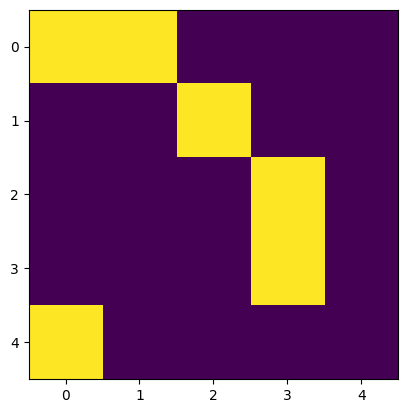

0            1.0
1            2.0
2            3.0
3            3.0
4            0.0
5            0.0
6            2.0
7            3.0
8            3.0
9            0.0
energy   -1952.0
Name: 5, dtype: float64


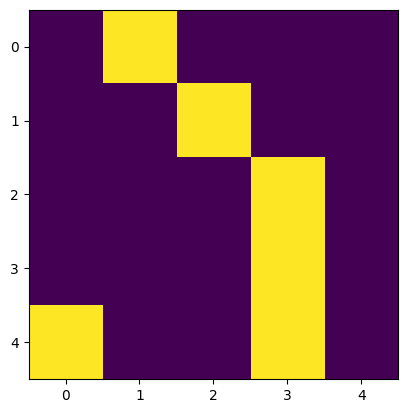

0            1.0
1            2.0
2            3.0
3            3.0
4            3.0
5            1.0
6            2.0
7            3.0
8            3.0
9            0.0
energy   -1952.0
Name: 6, dtype: float64


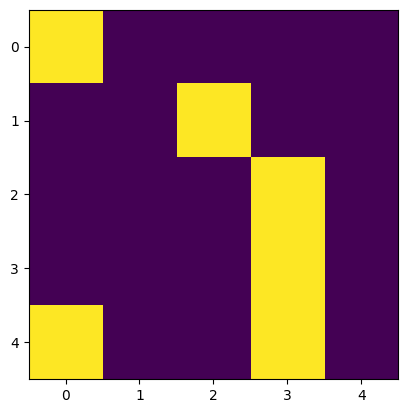

0            0.0
1            2.0
2            3.0
3            3.0
4            0.0
5            0.0
6            2.0
7            3.0
8            3.0
9            3.0
energy   -1952.0
Name: 7, dtype: float64


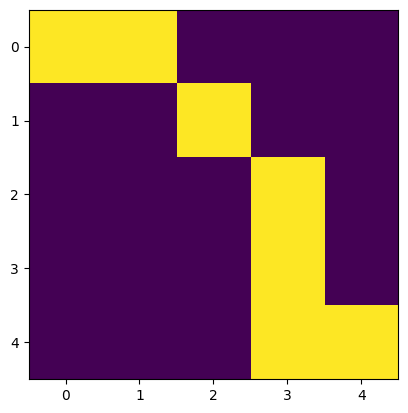

0            0.0
1            2.0
2            3.0
3            3.0
4            3.0
5            1.0
6            2.0
7            3.0
8            3.0
9            4.0
energy   -1952.0
Name: 8, dtype: float64


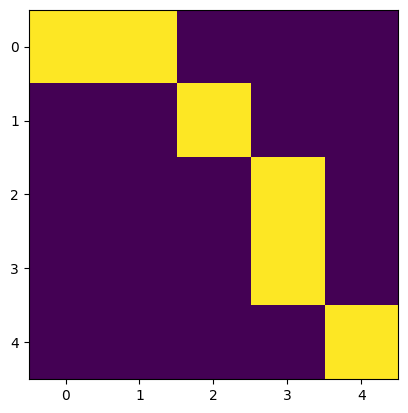

0            1.0
1            2.0
2            3.0
3            3.0
4            4.0
5            0.0
6            2.0
7            3.0
8            3.0
9            4.0
energy   -1952.0
Name: 9, dtype: float64


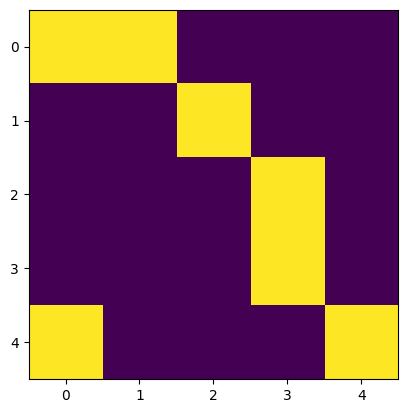

0            1.0
1            2.0
2            3.0
3            3.0
4            4.0
5            0.0
6            2.0
7            3.0
8            3.0
9            0.0
energy   -1952.0
Name: 10, dtype: float64


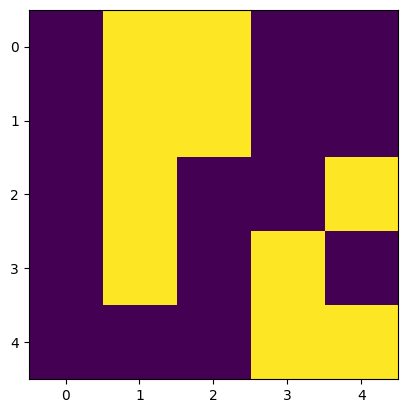

0           2.0
1           1.0
2           4.0
3           3.0
4           4.0
5           1.0
6           2.0
7           1.0
8           1.0
9           3.0
energy   -704.0
Name: 12, dtype: float64


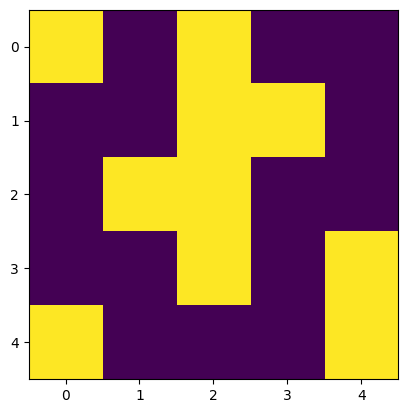

0            0.0
1            2.0
2            2.0
3            2.0
4            4.0
5            2.0
6            3.0
7            1.0
8            4.0
9            0.0
energy   -1112.0
Name: 13, dtype: float64


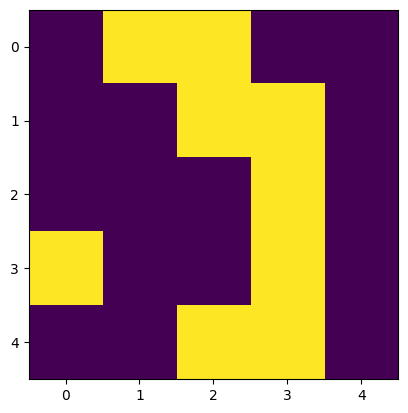

0            1.0
1            2.0
2            3.0
3            0.0
4            2.0
5            2.0
6            3.0
7            3.0
8            3.0
9            3.0
energy   -1392.0
Name: 14, dtype: float64


In [93]:
for i in range(df.shape[0]):
    make_img_dis(np.array(df_5.iloc[i,:2*n],dtype = 'int32'))
    print(df_5.iloc[i,:2*n+1])

In [31]:
### NON linear attempt

In [19]:
n = 9
#Linear weight matrix
#X_L[i,u] = ai,u
X_L = np.zeros((2*n,n))
for i,j,k in N_3:
    for s,r,t in B:
        for u1,u2,u3 in N_3:
            X_L[s*n + i,u1] -= ((k - j)**2) * u1**2
            X_L[r*n + j,u2] -= ((i - k)**2) * u2**2
            X_L[t*n + k,u3] -= ((j - i)**2) * u3**2


#X_Q[i,j,u,v] := ai,u * aj,v
X_Q = np.zeros((2*n,2*n,n,n))
for i,j,k in N_3:
    for s,r,t in B:
        for u1,u2,u3,v1,v2,v3 in N6:
            if (u1 != u2 or u2 != u3) and (v1 != v2 or v2 != v3) and (u1 != v2) and (u1!=v3) and (u2 != v1) and (u2 != v3) and (u3 != v1) and (u3 != v2):
                X_Q[s*n + i,r*n + j][u1,v1] -= 2*(k - j)*(i - k)*u1*v1
                X_Q[s*n + i,t*n + k][u2,v2] -= 2*(k - j)*(j - i)*u2*v2
                X_Q[r*n + j,t*n + k][u3,v3] -= 2*(i - k)*(j - i)*u3*v3
               # print(2*(k - j)*(i - k)*u1*v1,2*(k - j)*(j - i)*u2*v2,2*(i - k)*(j - i)*u3*v3)

In [8]:
X_Q[2,1],X_Q[3,1]

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  96.,  96.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  96., 384.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [9]:
#Add linear costs:
dqm = dimod.DiscreteQuadraticModel()
dis_vars = []
for i in range(2*n):
    dis_vars.append(dqm.add_variable(n))
    for case in range(n):
        dqm.set_linear_case(dis_vars[i],case,X_L[i,case])


#Add quadratic costs:
for a,b in [prod for prod in itertools.product(range(2*n), repeat = 2)]:
    for u,v in [cases for cases in itertools.product(range(n), repeat = 2)]:
        if a != b:
            dqm.set_quadratic(dis_vars[a],dis_vars[b], {(u,v) : X_Q[a,b][u,v]})



In [10]:
from dwave.system import LeapHybridDQMSampler
dqm_sampler = LeapHybridDQMSampler()
sampleset = dqm_sampler.sample_dqm(dqm)  
df_NL = sampleset.to_pandas_dataframe().drop_duplicates()

In [11]:
sampleset

SampleSet(rec.array([([3, 2, 4, 2, 6, 4, 0, 8, 0, 7, 2, 4, 0, 3, 5, 0, 6, 3], -1536., 1),
           ([8, 2, 5, 2, 0, 2, 2, 6, 1, 0, 2, 5, 0, 0, 2, 0, 2, 6], -1536., 1),
           ([0, 2, 4, 7, 1, 4, 6, 8, 0, 3, 2, 4, 2, 3, 7, 7, 7, 3], -1536., 1),
           ([7, 2, 3, 3, 3, 0, 0, 6, 5, 5, 2, 3, 2, 0, 3, 5, 7, 6], -1536., 1),
           ([3, 2, 5, 3, 1, 4, 3, 4, 3, 7, 2, 4, 2, 3, 5, 0, 2, 3], -1536., 1),
           ([7, 2, 3, 3, 3, 8, 6, 7, 1, 3, 2, 3, 2, 4, 6, 5, 5, 7], -1536., 1),
           ([8, 2, 4, 7, 1, 7, 2, 8, 0, 7, 2, 4, 3, 3, 8, 4, 6, 0], -1536., 1),
           ([3, 2, 4, 6, 7, 3, 6, 6, 0, 5, 2, 6, 2, 7, 7, 0, 7, 6], -1536., 1),
           ([8, 2, 7, 5, 0, 7, 0, 4, 3, 0, 2, 8, 3, 0, 8, 3, 2, 5], -1536., 1),
           ([4, 2, 5, 0, 8, 7, 0, 0, 1, 6, 2, 6, 0, 5, 5, 0, 5, 4], -1536., 1),
           ([4, 2, 7, 6, 8, 3, 6, 0, 1, 6, 2, 3, 2, 7, 7, 7, 7, 4], -1536., 1),
           ([4, 2, 4, 3, 7, 2, 0, 6, 0, 3, 2, 8, 5, 7, 7, 1, 5, 7], -1536., 1),
           ([8, 2, 7, 5, 0, 7,

In [13]:
df_NL

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,energy,num_occurrences
0,3,2,4,2,6,4,0,8,0,7,2,4,0,3,5,0,6,3,-1536.0,1
1,8,2,5,2,0,2,2,6,1,0,2,5,0,0,2,0,2,6,-1536.0,1
2,0,2,4,7,1,4,6,8,0,3,2,4,2,3,7,7,7,3,-1536.0,1
3,7,2,3,3,3,0,0,6,5,5,2,3,2,0,3,5,7,6,-1536.0,1
4,3,2,5,3,1,4,3,4,3,7,2,4,2,3,5,0,2,3,-1536.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,7,2,3,3,3,0,0,7,5,3,2,3,2,0,3,5,7,7,-1536.0,1
85,0,2,4,6,7,3,6,6,0,3,2,6,2,7,7,7,7,4,-1536.0,1
86,4,2,4,3,5,2,0,4,0,3,2,8,5,3,2,1,5,7,-1536.0,1
87,8,2,7,5,0,7,0,0,7,8,2,5,3,3,8,4,7,0,-1536.0,1


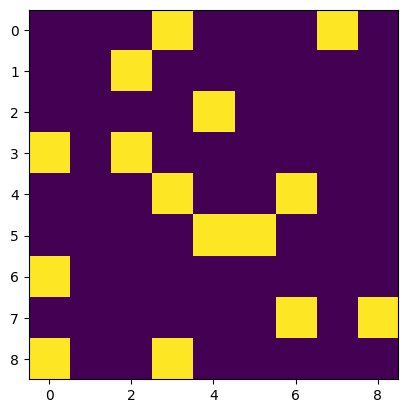

0            3.0
1            2.0
2            4.0
3            2.0
4            6.0
5            4.0
6            0.0
7            8.0
8            0.0
9            7.0
10           2.0
11           4.0
12           0.0
13           3.0
14           5.0
15           0.0
16           6.0
17           3.0
energy   -1536.0
Name: 0, dtype: float64


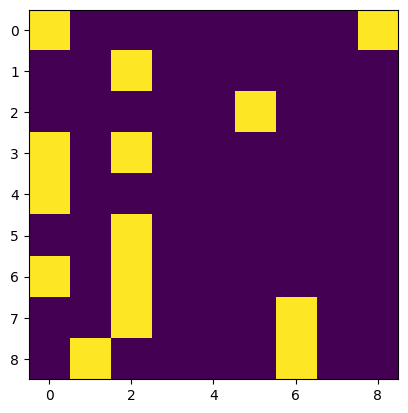

0            8.0
1            2.0
2            5.0
3            2.0
4            0.0
5            2.0
6            2.0
7            6.0
8            1.0
9            0.0
10           2.0
11           5.0
12           0.0
13           0.0
14           2.0
15           0.0
16           2.0
17           6.0
energy   -1536.0
Name: 1, dtype: float64


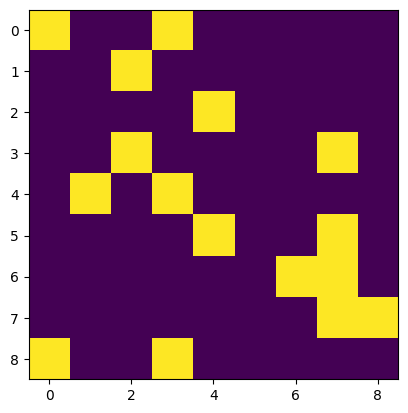

0            0.0
1            2.0
2            4.0
3            7.0
4            1.0
5            4.0
6            6.0
7            8.0
8            0.0
9            3.0
10           2.0
11           4.0
12           2.0
13           3.0
14           7.0
15           7.0
16           7.0
17           3.0
energy   -1536.0
Name: 2, dtype: float64


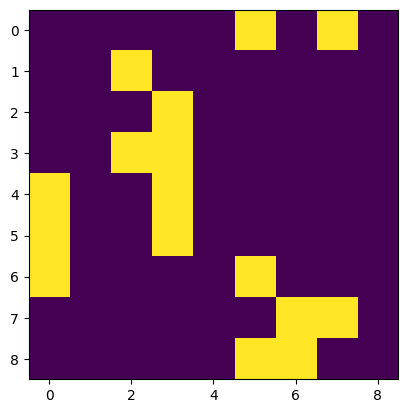

0            7.0
1            2.0
2            3.0
3            3.0
4            3.0
5            0.0
6            0.0
7            6.0
8            5.0
9            5.0
10           2.0
11           3.0
12           2.0
13           0.0
14           3.0
15           5.0
16           7.0
17           6.0
energy   -1536.0
Name: 3, dtype: float64


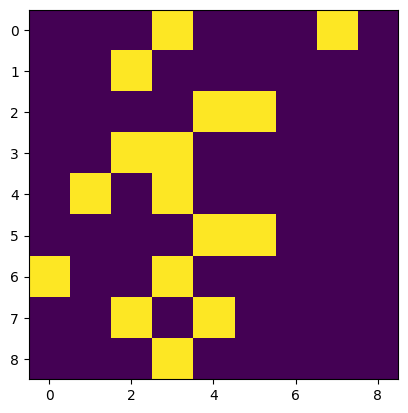

0            3.0
1            2.0
2            5.0
3            3.0
4            1.0
5            4.0
6            3.0
7            4.0
8            3.0
9            7.0
10           2.0
11           4.0
12           2.0
13           3.0
14           5.0
15           0.0
16           2.0
17           3.0
energy   -1536.0
Name: 4, dtype: float64


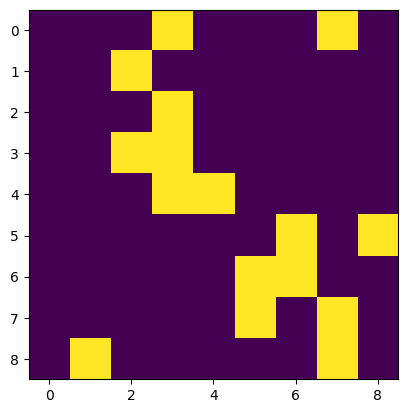

0            7.0
1            2.0
2            3.0
3            3.0
4            3.0
5            8.0
6            6.0
7            7.0
8            1.0
9            3.0
10           2.0
11           3.0
12           2.0
13           4.0
14           6.0
15           5.0
16           5.0
17           7.0
energy   -1536.0
Name: 5, dtype: float64


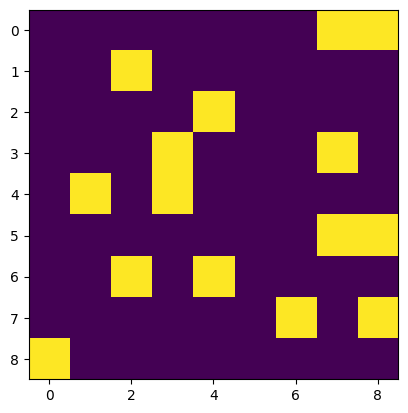

0            8.0
1            2.0
2            4.0
3            7.0
4            1.0
5            7.0
6            2.0
7            8.0
8            0.0
9            7.0
10           2.0
11           4.0
12           3.0
13           3.0
14           8.0
15           4.0
16           6.0
17           0.0
energy   -1536.0
Name: 6, dtype: float64


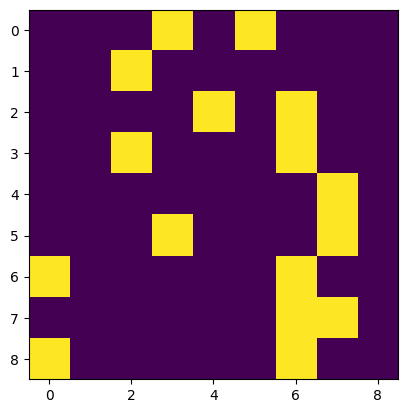

0            3.0
1            2.0
2            4.0
3            6.0
4            7.0
5            3.0
6            6.0
7            6.0
8            0.0
9            5.0
10           2.0
11           6.0
12           2.0
13           7.0
14           7.0
15           0.0
16           7.0
17           6.0
energy   -1536.0
Name: 7, dtype: float64


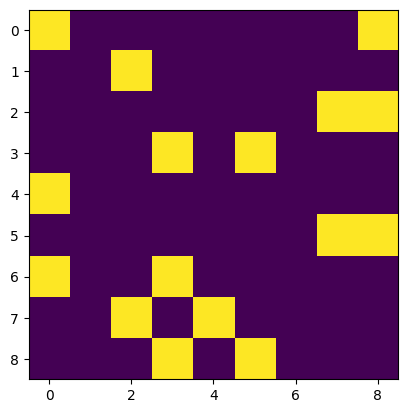

0            8.0
1            2.0
2            7.0
3            5.0
4            0.0
5            7.0
6            0.0
7            4.0
8            3.0
9            0.0
10           2.0
11           8.0
12           3.0
13           0.0
14           8.0
15           3.0
16           2.0
17           5.0
energy   -1536.0
Name: 8, dtype: float64


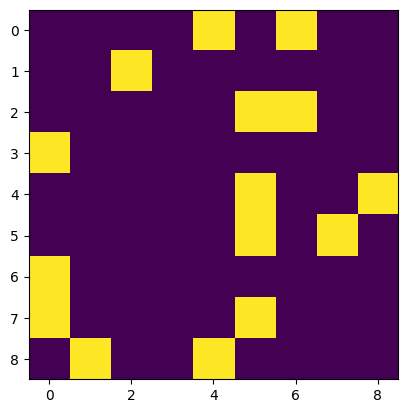

0            4.0
1            2.0
2            5.0
3            0.0
4            8.0
5            7.0
6            0.0
7            0.0
8            1.0
9            6.0
10           2.0
11           6.0
12           0.0
13           5.0
14           5.0
15           0.0
16           5.0
17           4.0
energy   -1536.0
Name: 9, dtype: float64


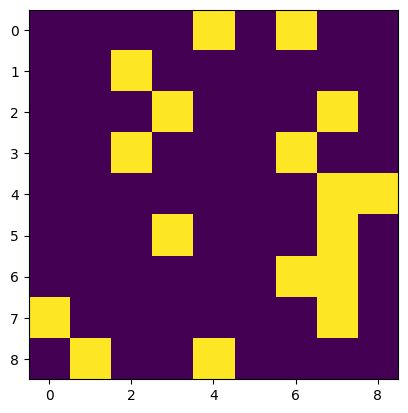

0            4.0
1            2.0
2            7.0
3            6.0
4            8.0
5            3.0
6            6.0
7            0.0
8            1.0
9            6.0
10           2.0
11           3.0
12           2.0
13           7.0
14           7.0
15           7.0
16           7.0
17           4.0
energy   -1536.0
Name: 10, dtype: float64


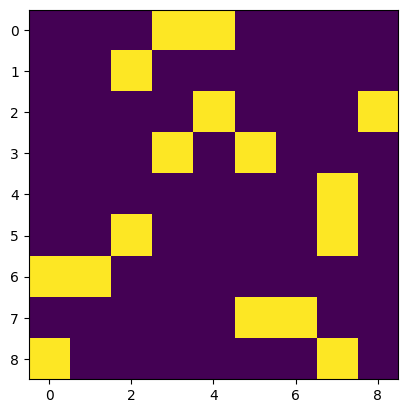

0            4.0
1            2.0
2            4.0
3            3.0
4            7.0
5            2.0
6            0.0
7            6.0
8            0.0
9            3.0
10           2.0
11           8.0
12           5.0
13           7.0
14           7.0
15           1.0
16           5.0
17           7.0
energy   -1536.0
Name: 11, dtype: float64


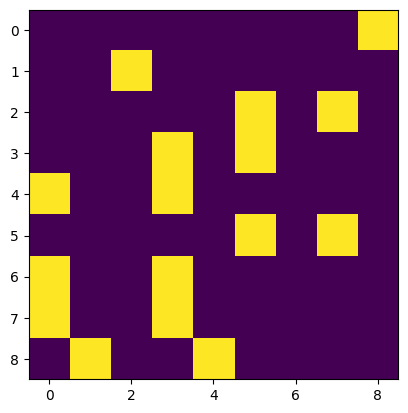

0            8.0
1            2.0
2            7.0
3            5.0
4            0.0
5            7.0
6            0.0
7            0.0
8            1.0
9            8.0
10           2.0
11           5.0
12           3.0
13           3.0
14           5.0
15           3.0
16           3.0
17           4.0
energy   -1536.0
Name: 12, dtype: float64


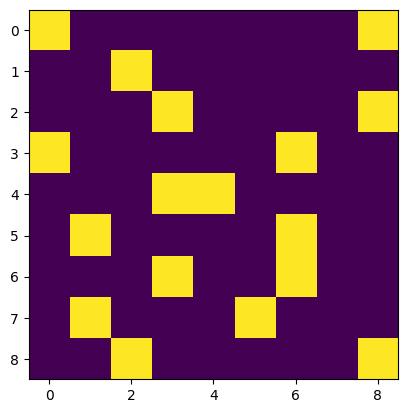

0            0.0
1            2.0
2            8.0
3            6.0
4            3.0
5            1.0
6            6.0
7            1.0
8            2.0
9            8.0
10           2.0
11           3.0
12           0.0
13           4.0
14           6.0
15           3.0
16           5.0
17           8.0
energy   -1536.0
Name: 13, dtype: float64


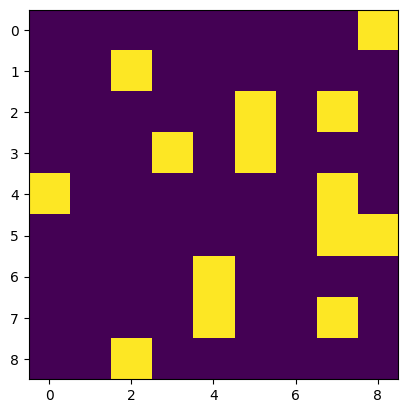

0            8.0
1            2.0
2            7.0
3            5.0
4            0.0
5            7.0
6            4.0
7            4.0
8            2.0
9            8.0
10           2.0
11           5.0
12           3.0
13           7.0
14           8.0
15           4.0
16           7.0
17           2.0
energy   -1536.0
Name: 14, dtype: float64


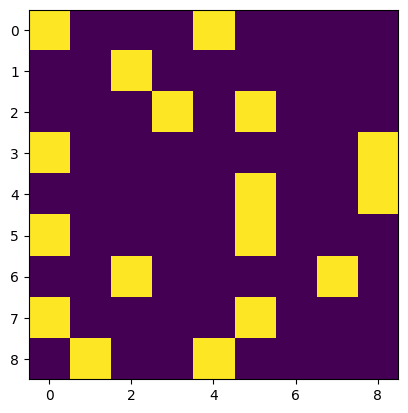

0            4.0
1            2.0
2            3.0
3            0.0
4            8.0
5            0.0
6            7.0
7            0.0
8            1.0
9            0.0
10           2.0
11           5.0
12           8.0
13           5.0
14           5.0
15           2.0
16           5.0
17           4.0
energy   -1536.0
Name: 15, dtype: float64


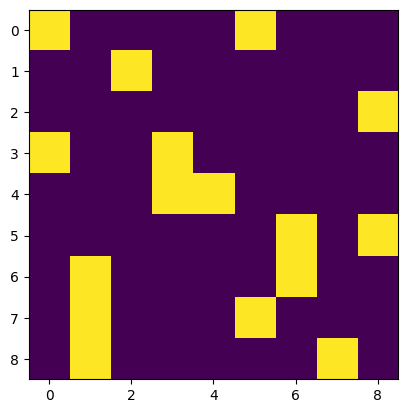

0            5.0
1            2.0
2            8.0
3            3.0
4            3.0
5            8.0
6            6.0
7            1.0
8            1.0
9            0.0
10           2.0
11           8.0
12           0.0
13           4.0
14           6.0
15           1.0
16           5.0
17           7.0
energy   -1536.0
Name: 16, dtype: float64


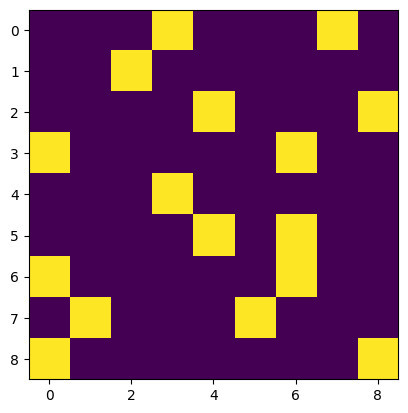

0            3.0
1            2.0
2            8.0
3            6.0
4            3.0
5            4.0
6            6.0
7            1.0
8            0.0
9            7.0
10           2.0
11           4.0
12           0.0
13           3.0
14           6.0
15           0.0
16           5.0
17           8.0
energy   -1536.0
Name: 17, dtype: float64


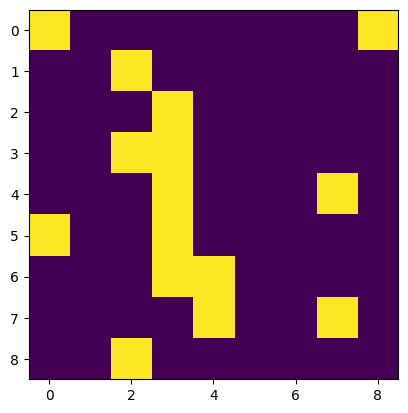

0            0.0
1            2.0
2            3.0
3            3.0
4            3.0
5            0.0
6            4.0
7            4.0
8            2.0
9            8.0
10           2.0
11           3.0
12           2.0
13           7.0
14           3.0
15           3.0
16           7.0
17           2.0
energy   -1536.0
Name: 18, dtype: float64


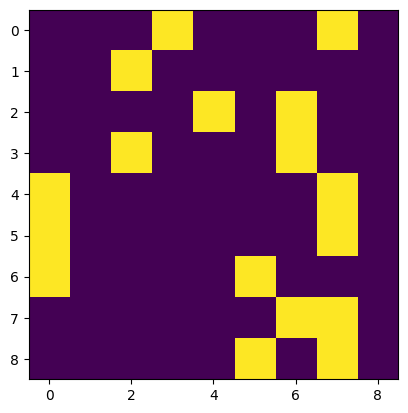

0            7.0
1            2.0
2            4.0
3            6.0
4            7.0
5            0.0
6            0.0
7            6.0
8            5.0
9            3.0
10           2.0
11           6.0
12           2.0
13           0.0
14           7.0
15           5.0
16           7.0
17           7.0
energy   -1536.0
Name: 19, dtype: float64


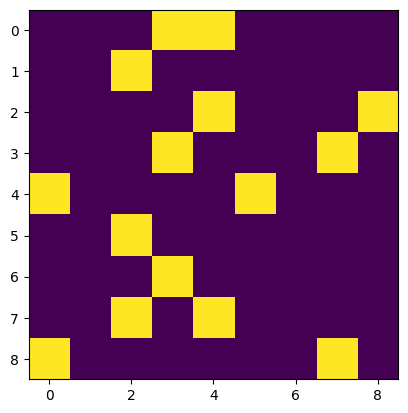

0            4.0
1            2.0
2            4.0
3            3.0
4            5.0
5            2.0
6            3.0
7            4.0
8            0.0
9            3.0
10           2.0
11           8.0
12           7.0
13           0.0
14           2.0
15           3.0
16           2.0
17           7.0
energy   -1536.0
Name: 20, dtype: float64


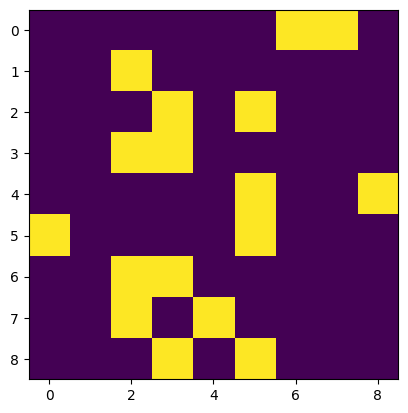

0            7.0
1            2.0
2            5.0
3            3.0
4            8.0
5            0.0
6            3.0
7            4.0
8            3.0
9            6.0
10           2.0
11           3.0
12           2.0
13           5.0
14           5.0
15           2.0
16           2.0
17           5.0
energy   -1536.0
Name: 21, dtype: float64


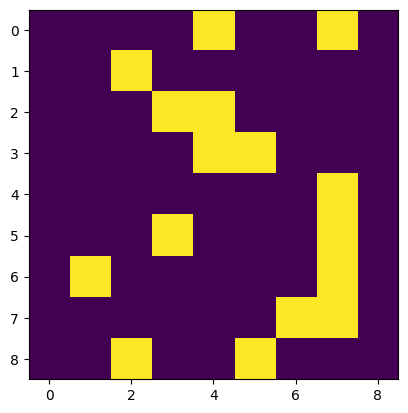

0            7.0
1            2.0
2            4.0
3            5.0
4            7.0
5            3.0
6            1.0
7            6.0
8            5.0
9            4.0
10           2.0
11           3.0
12           4.0
13           7.0
14           7.0
15           7.0
16           7.0
17           2.0
energy   -1536.0
Name: 22, dtype: float64


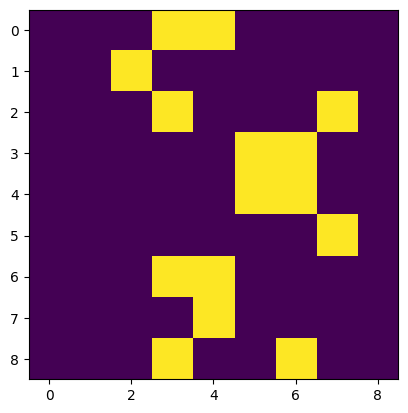

0            3.0
1            2.0
2            3.0
3            6.0
4            5.0
5            7.0
6            4.0
7            4.0
8            6.0
9            4.0
10           2.0
11           7.0
12           5.0
13           6.0
14           7.0
15           3.0
16           4.0
17           3.0
energy   -1536.0
Name: 23, dtype: float64


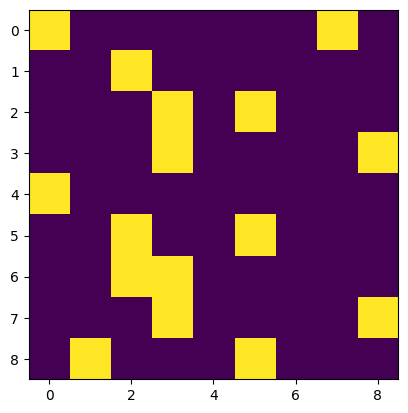

0            7.0
1            2.0
2            3.0
3            3.0
4            0.0
5            2.0
6            2.0
7            8.0
8            1.0
9            0.0
10           2.0
11           5.0
12           8.0
13           0.0
14           5.0
15           3.0
16           3.0
17           5.0
energy   -1536.0
Name: 24, dtype: float64


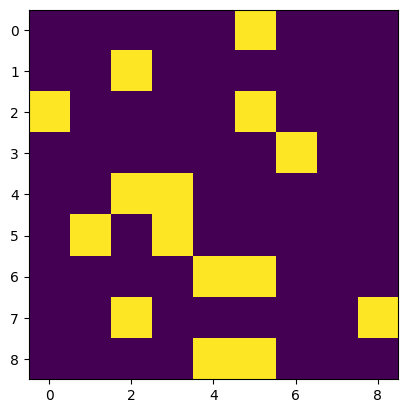

0            5.0
1            2.0
2            0.0
3            6.0
4            2.0
5            1.0
6            4.0
7            8.0
8            4.0
9            5.0
10           2.0
11           5.0
12           6.0
13           3.0
14           3.0
15           5.0
16           2.0
17           5.0
energy   -1536.0
Name: 25, dtype: float64


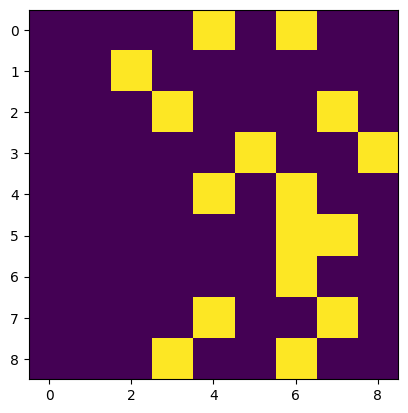

0            6.0
1            2.0
2            3.0
3            8.0
4            4.0
5            6.0
6            6.0
7            7.0
8            6.0
9            4.0
10           2.0
11           7.0
12           5.0
13           6.0
14           7.0
15           6.0
16           4.0
17           3.0
energy   -1536.0
Name: 26, dtype: float64


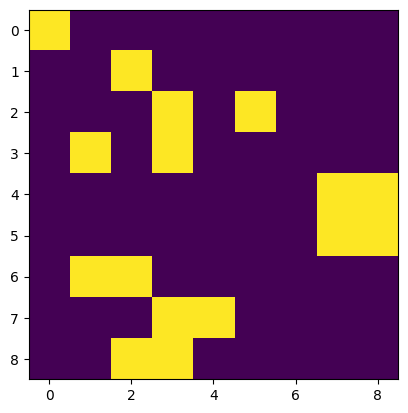

0            0.0
1            2.0
2            3.0
3            1.0
4            8.0
5            7.0
6            1.0
7            4.0
8            3.0
9            0.0
10           2.0
11           5.0
12           3.0
13           7.0
14           8.0
15           2.0
16           3.0
17           2.0
energy   -1536.0
Name: 27, dtype: float64


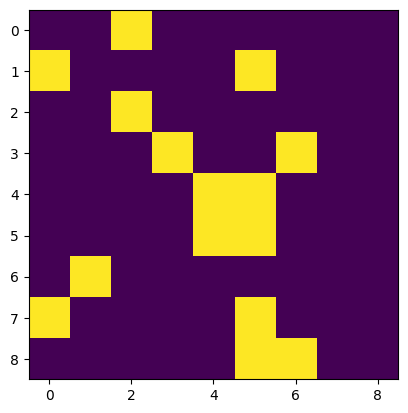

0            2.0
1            5.0
2            2.0
3            3.0
4            5.0
5            5.0
6            1.0
7            5.0
8            6.0
9            2.0
10           0.0
11           2.0
12           6.0
13           4.0
14           4.0
15           1.0
16           0.0
17           5.0
energy   -1536.0
Name: 28, dtype: float64


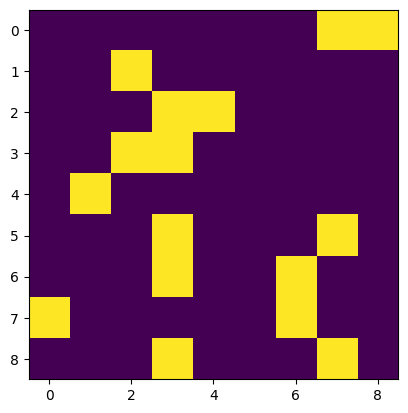

0            7.0
1            2.0
2            4.0
3            2.0
4            1.0
5            3.0
6            6.0
7            6.0
8            7.0
9            8.0
10           2.0
11           3.0
12           3.0
13           1.0
14           7.0
15           3.0
16           0.0
17           3.0
energy   -1536.0
Name: 29, dtype: float64


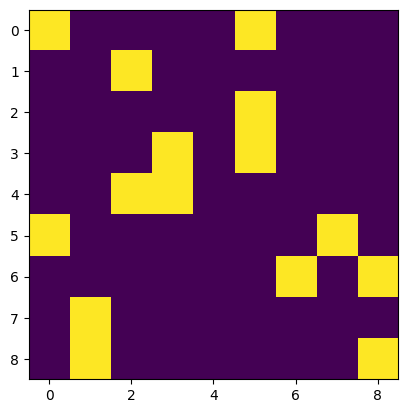

0            5.0
1            2.0
2            5.0
3            3.0
4            2.0
5            7.0
6            6.0
7            1.0
8            8.0
9            0.0
10           2.0
11           5.0
12           5.0
13           3.0
14           0.0
15           8.0
16           1.0
17           1.0
energy   -1536.0
Name: 30, dtype: float64


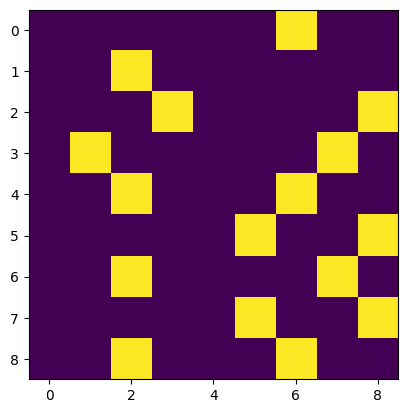

0            6.0
1            2.0
2            3.0
3            7.0
4            2.0
5            8.0
6            2.0
7            8.0
8            6.0
9            6.0
10           2.0
11           8.0
12           1.0
13           6.0
14           5.0
15           7.0
16           5.0
17           2.0
energy   -1536.0
Name: 31, dtype: float64


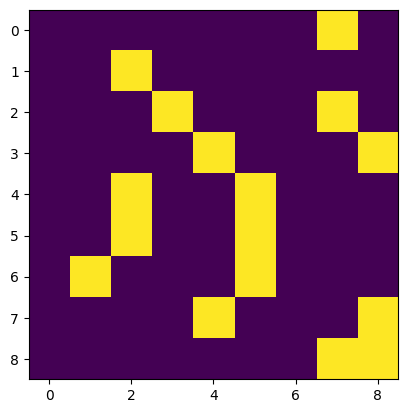

0            7.0
1            2.0
2            3.0
3            4.0
4            2.0
5            2.0
6            1.0
7            4.0
8            7.0
9            7.0
10           2.0
11           7.0
12           8.0
13           5.0
14           5.0
15           5.0
16           8.0
17           8.0
energy   -1536.0
Name: 32, dtype: float64


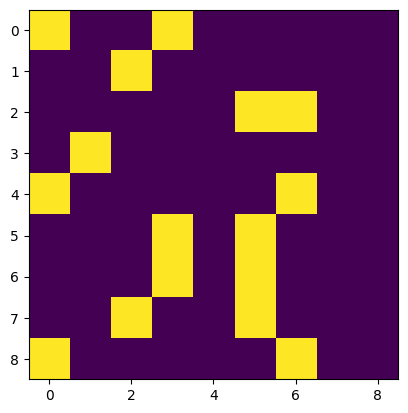

0            0.0
1            2.0
2            6.0
3            1.0
4            0.0
5            5.0
6            5.0
7            5.0
8            0.0
9            3.0
10           2.0
11           5.0
12           1.0
13           6.0
14           3.0
15           3.0
16           2.0
17           6.0
energy   -1536.0
Name: 33, dtype: float64


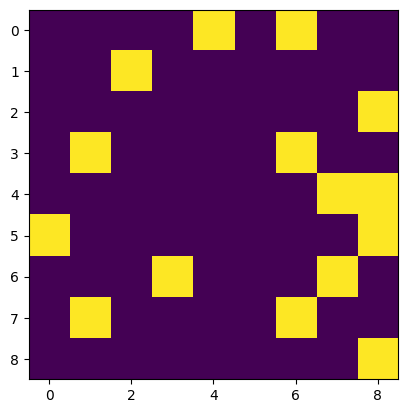

0            6.0
1            2.0
2            8.0
3            6.0
4            7.0
5            8.0
6            7.0
7            1.0
8            8.0
9            4.0
10           2.0
11           8.0
12           1.0
13           8.0
14           0.0
15           3.0
16           6.0
17           8.0
energy   -1536.0
Name: 34, dtype: float64


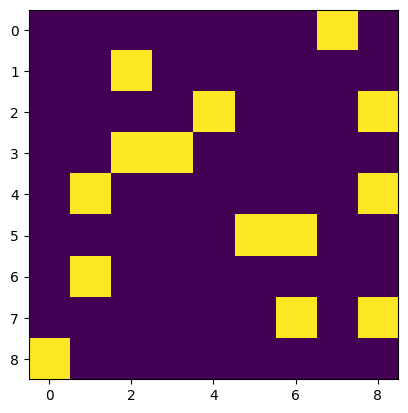

0            7.0
1            2.0
2            8.0
3            2.0
4            1.0
5            6.0
6            1.0
7            8.0
8            0.0
9            7.0
10           2.0
11           4.0
12           3.0
13           8.0
14           5.0
15           1.0
16           6.0
17           0.0
energy   -1536.0
Name: 35, dtype: float64


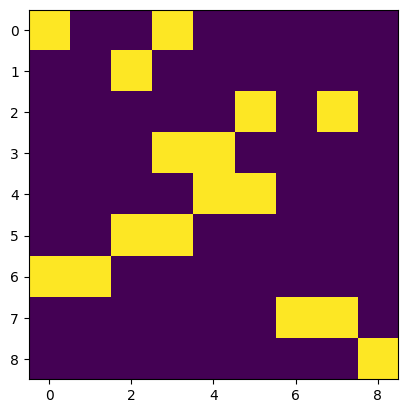

0            3.0
1            2.0
2            5.0
3            4.0
4            5.0
5            2.0
6            1.0
7            6.0
8            8.0
9            0.0
10           2.0
11           7.0
12           3.0
13           4.0
14           3.0
15           0.0
16           7.0
17           8.0
energy   -1536.0
Name: 36, dtype: float64


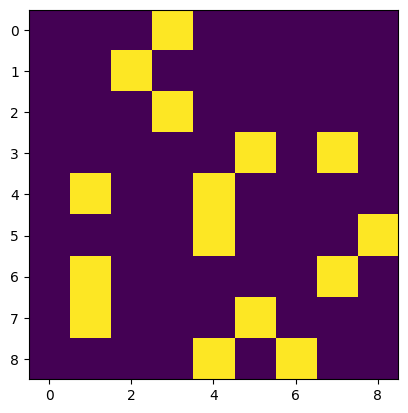

0            3.0
1            2.0
2            3.0
3            7.0
4            1.0
5            8.0
6            1.0
7            5.0
8            4.0
9            3.0
10           2.0
11           3.0
12           5.0
13           4.0
14           4.0
15           7.0
16           1.0
17           6.0
energy   -1536.0
Name: 37, dtype: float64


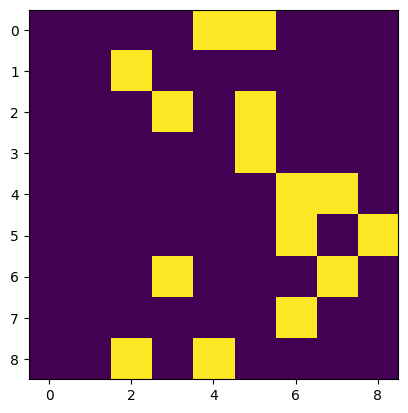

0            5.0
1            2.0
2            5.0
3            5.0
4            6.0
5            8.0
6            7.0
7            6.0
8            2.0
9            4.0
10           2.0
11           3.0
12           5.0
13           7.0
14           6.0
15           3.0
16           6.0
17           4.0
energy   -1536.0
Name: 38, dtype: float64


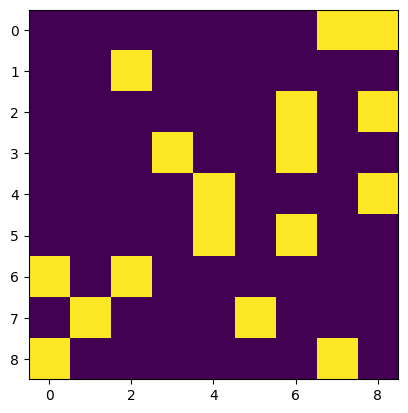

0            8.0
1            2.0
2            6.0
3            6.0
4            4.0
5            4.0
6            0.0
7            1.0
8            0.0
9            7.0
10           2.0
11           8.0
12           3.0
13           8.0
14           6.0
15           2.0
16           5.0
17           7.0
energy   -1536.0
Name: 39, dtype: float64


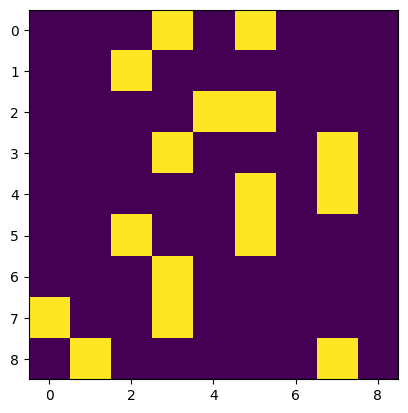

0            5.0
1            2.0
2            4.0
3            7.0
4            7.0
5            5.0
6            3.0
7            0.0
8            7.0
9            3.0
10           2.0
11           5.0
12           3.0
13           5.0
14           2.0
15           3.0
16           3.0
17           1.0
energy   -1536.0
Name: 40, dtype: float64


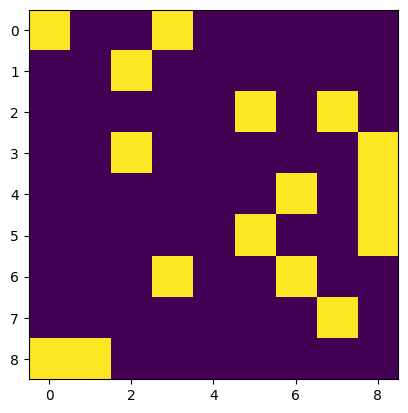

0            0.0
1            2.0
2            5.0
3            2.0
4            6.0
5            5.0
6            6.0
7            7.0
8            1.0
9            3.0
10           2.0
11           7.0
12           8.0
13           8.0
14           8.0
15           3.0
16           7.0
17           0.0
energy   -1536.0
Name: 41, dtype: float64


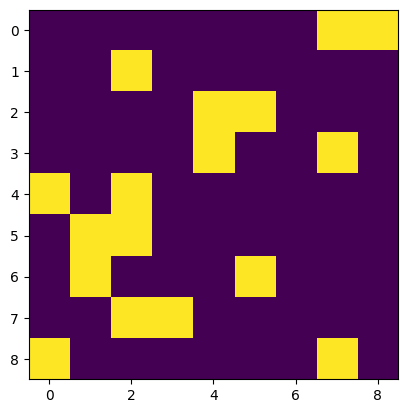

0            8.0
1            2.0
2            4.0
3            4.0
4            2.0
5            2.0
6            5.0
7            3.0
8            0.0
9            7.0
10           2.0
11           5.0
12           7.0
13           0.0
14           1.0
15           1.0
16           2.0
17           7.0
energy   -1536.0
Name: 42, dtype: float64


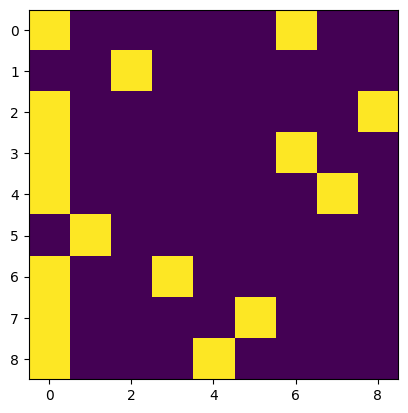

0            6.0
1            2.0
2            0.0
3            6.0
4            7.0
5            1.0
6            0.0
7            5.0
8            4.0
9            0.0
10           2.0
11           8.0
12           0.0
13           0.0
14           1.0
15           3.0
16           0.0
17           0.0
energy   -1536.0
Name: 43, dtype: float64


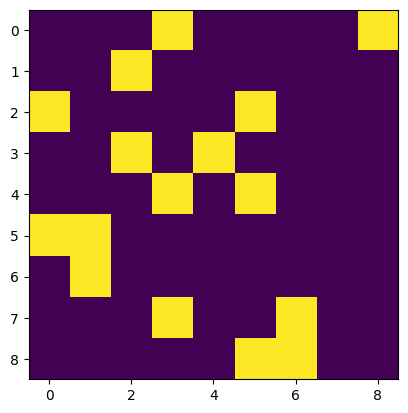

0            8.0
1            2.0
2            5.0
3            2.0
4            5.0
5            0.0
6            1.0
7            3.0
8            6.0
9            3.0
10           2.0
11           0.0
12           4.0
13           3.0
14           1.0
15           1.0
16           6.0
17           5.0
energy   -1536.0
Name: 44, dtype: float64


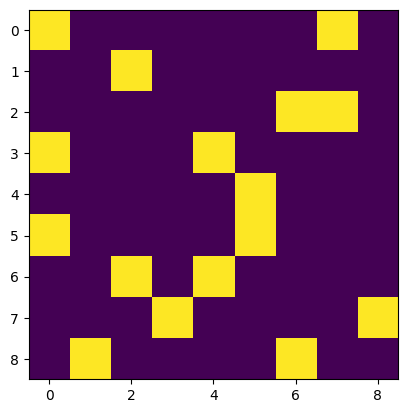

0            7.0
1            2.0
2            6.0
3            4.0
4            5.0
5            5.0
6            2.0
7            3.0
8            1.0
9            0.0
10           2.0
11           7.0
12           0.0
13           5.0
14           0.0
15           4.0
16           8.0
17           6.0
energy   -1536.0
Name: 45, dtype: float64


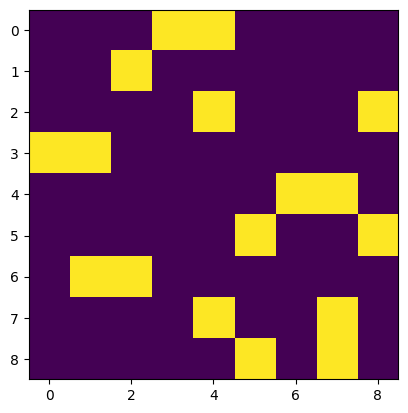

0            3.0
1            2.0
2            4.0
3            0.0
4            6.0
5            5.0
6            1.0
7            4.0
8            5.0
9            4.0
10           2.0
11           8.0
12           1.0
13           7.0
14           8.0
15           2.0
16           7.0
17           7.0
energy   -1536.0
Name: 46, dtype: float64


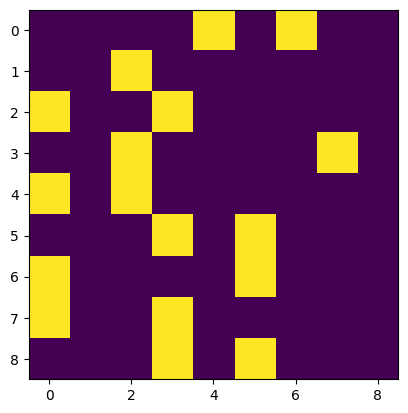

0            6.0
1            2.0
2            0.0
3            7.0
4            0.0
5            3.0
6            5.0
7            3.0
8            5.0
9            4.0
10           2.0
11           3.0
12           2.0
13           2.0
14           5.0
15           0.0
16           0.0
17           3.0
energy   -1536.0
Name: 47, dtype: float64


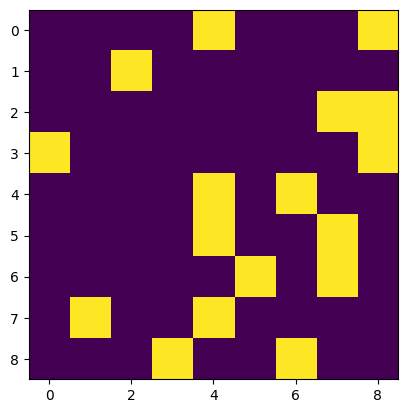

0            4.0
1            2.0
2            7.0
3            0.0
4            6.0
5            7.0
6            5.0
7            1.0
8            3.0
9            8.0
10           2.0
11           8.0
12           8.0
13           4.0
14           4.0
15           7.0
16           4.0
17           6.0
energy   -1536.0
Name: 48, dtype: float64


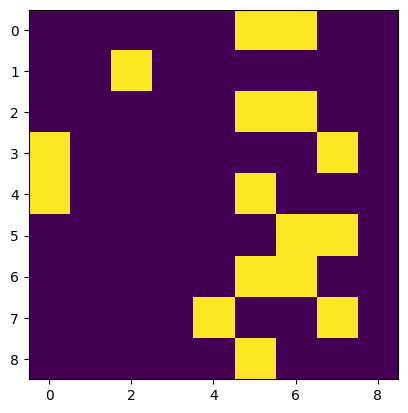

0            5.0
1            2.0
2            6.0
3            0.0
4            0.0
5            7.0
6            5.0
7            7.0
8            5.0
9            6.0
10           2.0
11           5.0
12           7.0
13           5.0
14           6.0
15           6.0
16           4.0
17           5.0
energy   -1536.0
Name: 49, dtype: float64


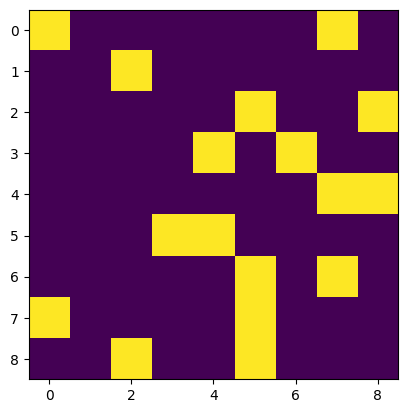

0            0.0
1            2.0
2            5.0
3            4.0
4            7.0
5            4.0
6            7.0
7            0.0
8            5.0
9            7.0
10           2.0
11           8.0
12           6.0
13           8.0
14           3.0
15           5.0
16           5.0
17           2.0
energy   -1536.0
Name: 50, dtype: float64


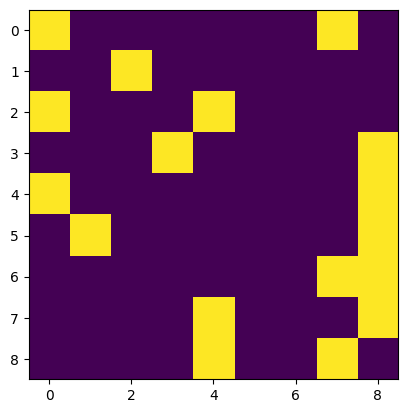

0            7.0
1            2.0
2            4.0
3            3.0
4            8.0
5            8.0
6            7.0
7            4.0
8            7.0
9            0.0
10           2.0
11           0.0
12           8.0
13           0.0
14           1.0
15           8.0
16           8.0
17           4.0
energy   -1536.0
Name: 51, dtype: float64


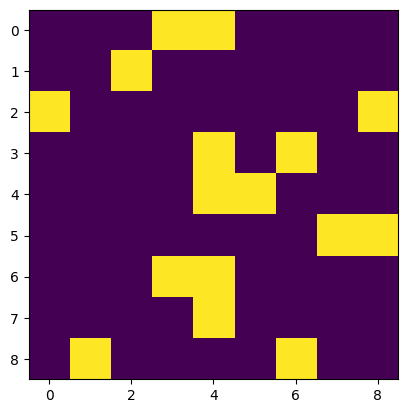

0            3.0
1            2.0
2            0.0
3            6.0
4            5.0
5            7.0
6            4.0
7            4.0
8            1.0
9            4.0
10           2.0
11           8.0
12           4.0
13           4.0
14           8.0
15           3.0
16           4.0
17           6.0
energy   -1536.0
Name: 52, dtype: float64


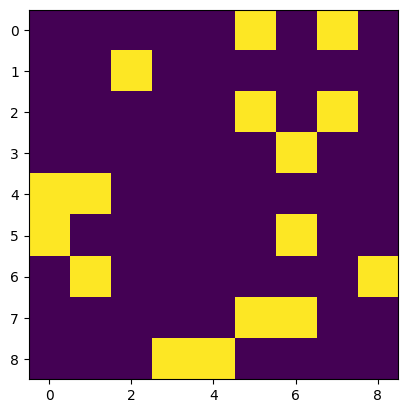

0            5.0
1            2.0
2            5.0
3            6.0
4            0.0
5            0.0
6            1.0
7            6.0
8            3.0
9            7.0
10           2.0
11           7.0
12           6.0
13           1.0
14           6.0
15           8.0
16           5.0
17           4.0
energy   -1536.0
Name: 53, dtype: float64


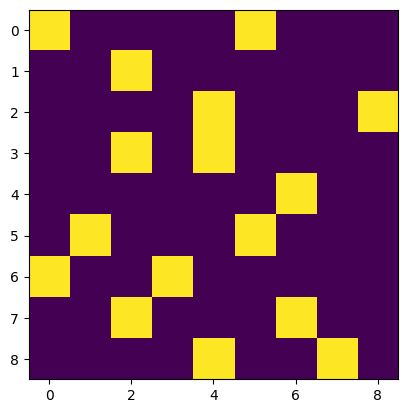

0            5.0
1            2.0
2            8.0
3            2.0
4            6.0
5            1.0
6            0.0
7            2.0
8            4.0
9            0.0
10           2.0
11           4.0
12           4.0
13           6.0
14           5.0
15           3.0
16           6.0
17           7.0
energy   -1536.0
Name: 54, dtype: float64


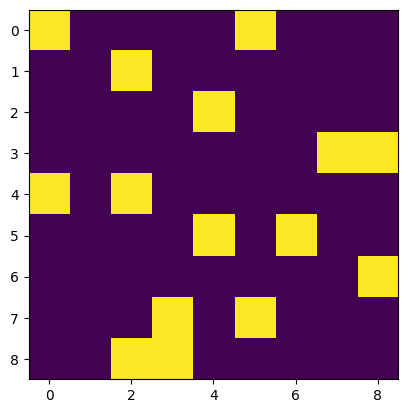

0            0.0
1            2.0
2            4.0
3            8.0
4            0.0
5            6.0
6            8.0
7            3.0
8            2.0
9            5.0
10           2.0
11           4.0
12           7.0
13           2.0
14           4.0
15           8.0
16           5.0
17           3.0
energy   -1536.0
Name: 55, dtype: float64


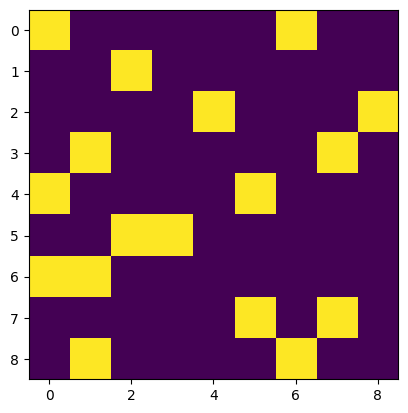

0            0.0
1            2.0
2            8.0
3            1.0
4            5.0
5            2.0
6            1.0
7            5.0
8            1.0
9            6.0
10           2.0
11           4.0
12           7.0
13           0.0
14           3.0
15           0.0
16           7.0
17           6.0
energy   -1536.0
Name: 56, dtype: float64


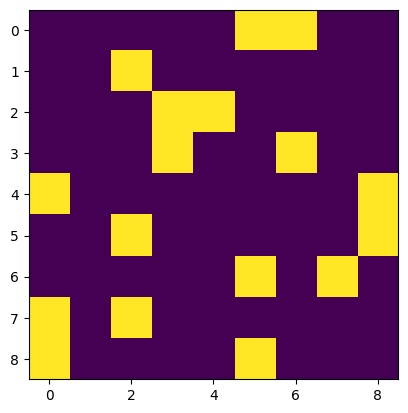

0            5.0
1            2.0
2            3.0
3            6.0
4            8.0
5            8.0
6            7.0
7            2.0
8            5.0
9            6.0
10           2.0
11           4.0
12           3.0
13           0.0
14           2.0
15           5.0
16           0.0
17           0.0
energy   -1536.0
Name: 57, dtype: float64


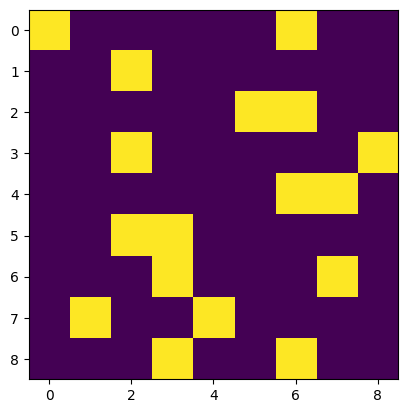

0            6.0
1            2.0
2            5.0
3            2.0
4            6.0
5            2.0
6            7.0
7            4.0
8            3.0
9            0.0
10           2.0
11           6.0
12           8.0
13           7.0
14           3.0
15           3.0
16           1.0
17           6.0
energy   -1536.0
Name: 58, dtype: float64


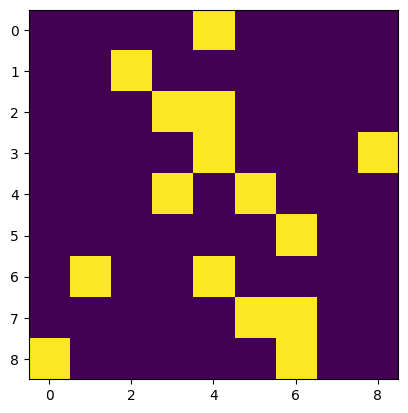

0            4.0
1            2.0
2            4.0
3            4.0
4            3.0
5            6.0
6            1.0
7            6.0
8            6.0
9            4.0
10           2.0
11           3.0
12           8.0
13           5.0
14           6.0
15           4.0
16           5.0
17           0.0
energy   -1536.0
Name: 59, dtype: float64


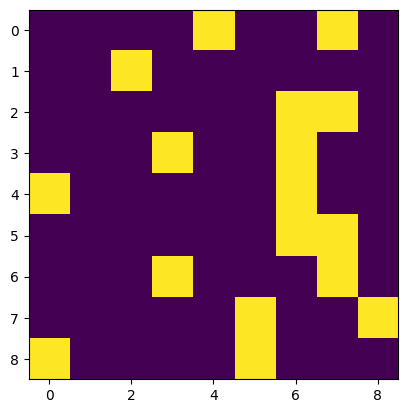

0            4.0
1            2.0
2            7.0
3            3.0
4            6.0
5            7.0
6            7.0
7            5.0
8            0.0
9            7.0
10           2.0
11           6.0
12           6.0
13           0.0
14           6.0
15           3.0
16           8.0
17           5.0
energy   -1536.0
Name: 60, dtype: float64


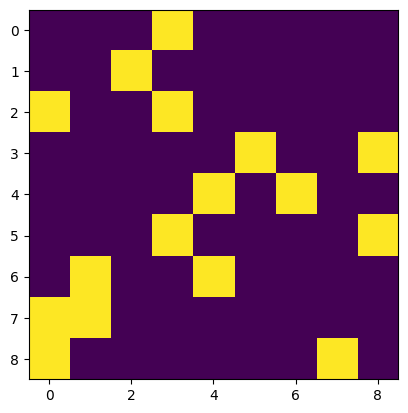

0            3.0
1            2.0
2            3.0
3            5.0
4            4.0
5            8.0
6            1.0
7            1.0
8            7.0
9            3.0
10           2.0
11           0.0
12           8.0
13           6.0
14           3.0
15           4.0
16           0.0
17           0.0
energy   -1536.0
Name: 61, dtype: float64


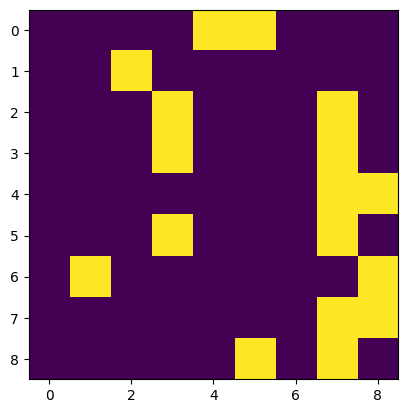

0            4.0
1            2.0
2            3.0
3            3.0
4            7.0
5            7.0
6            8.0
7            8.0
8            5.0
9            5.0
10           2.0
11           7.0
12           7.0
13           8.0
14           3.0
15           1.0
16           7.0
17           7.0
energy   -1536.0
Name: 62, dtype: float64


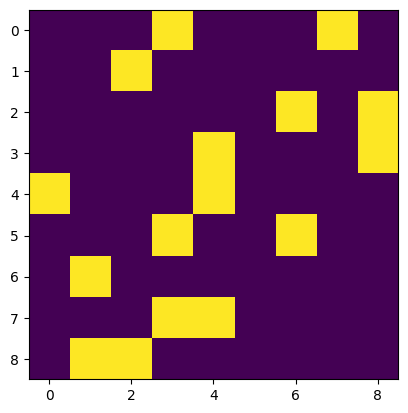

0            7.0
1            2.0
2            8.0
3            4.0
4            0.0
5            3.0
6            1.0
7            3.0
8            2.0
9            3.0
10           2.0
11           6.0
12           8.0
13           4.0
14           6.0
15           1.0
16           4.0
17           1.0
energy   -1536.0
Name: 63, dtype: float64


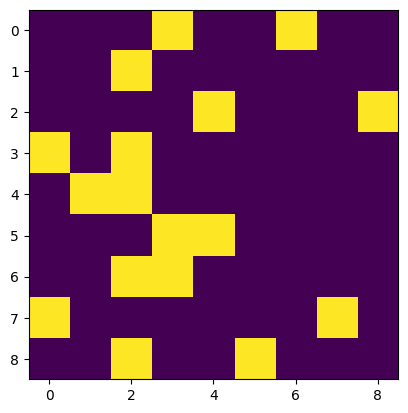

0            3.0
1            2.0
2            8.0
3            2.0
4            1.0
5            4.0
6            2.0
7            7.0
8            2.0
9            6.0
10           2.0
11           4.0
12           0.0
13           2.0
14           3.0
15           3.0
16           0.0
17           5.0
energy   -1536.0
Name: 64, dtype: float64


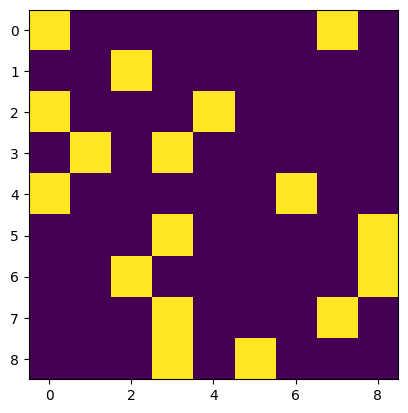

0            7.0
1            2.0
2            4.0
3            1.0
4            6.0
5            3.0
6            2.0
7            7.0
8            5.0
9            0.0
10           2.0
11           0.0
12           3.0
13           0.0
14           8.0
15           8.0
16           3.0
17           3.0
energy   -1536.0
Name: 65, dtype: float64


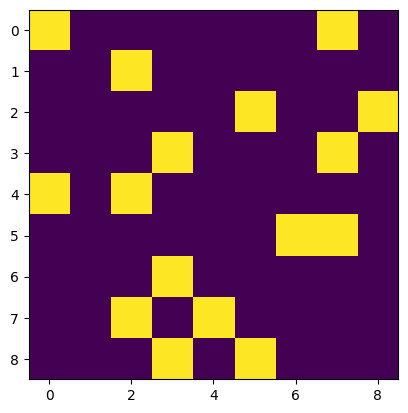

0            7.0
1            2.0
2            5.0
3            3.0
4            2.0
5            6.0
6            3.0
7            4.0
8            3.0
9            0.0
10           2.0
11           8.0
12           7.0
13           0.0
14           7.0
15           3.0
16           2.0
17           5.0
energy   -1536.0
Name: 66, dtype: float64


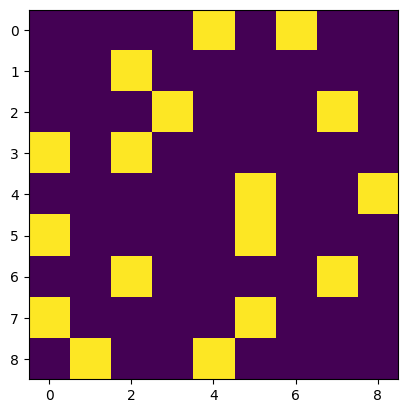

0            4.0
1            2.0
2            7.0
3            0.0
4            8.0
5            0.0
6            7.0
7            0.0
8            1.0
9            6.0
10           2.0
11           3.0
12           2.0
13           5.0
14           5.0
15           2.0
16           5.0
17           4.0
energy   -1536.0
Name: 67, dtype: float64


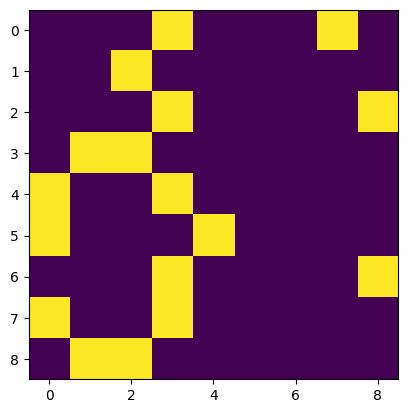

0            7.0
1            2.0
2            8.0
3            1.0
4            0.0
5            4.0
6            3.0
7            3.0
8            1.0
9            3.0
10           2.0
11           3.0
12           2.0
13           3.0
14           0.0
15           8.0
16           0.0
17           2.0
energy   -1536.0
Name: 68, dtype: float64


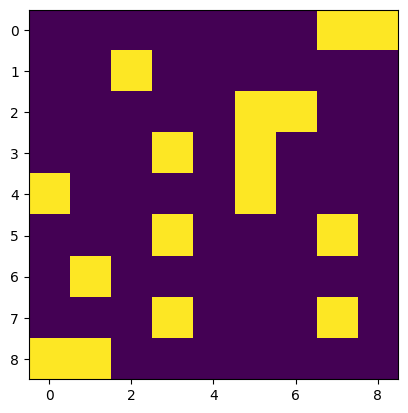

0            7.0
1            2.0
2            6.0
3            5.0
4            5.0
5            7.0
6            1.0
7            7.0
8            0.0
9            8.0
10           2.0
11           5.0
12           3.0
13           0.0
14           3.0
15           1.0
16           3.0
17           1.0
energy   -1536.0
Name: 69, dtype: float64


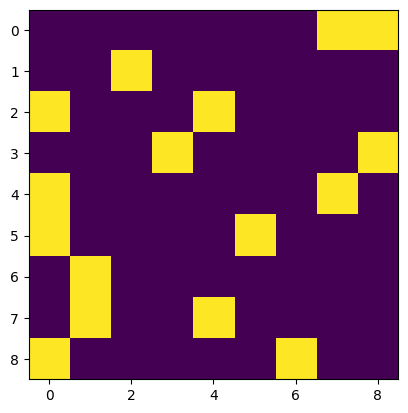

0            8.0
1            2.0
2            4.0
3            8.0
4            0.0
5            5.0
6            1.0
7            1.0
8            6.0
9            7.0
10           2.0
11           0.0
12           3.0
13           7.0
14           0.0
15           1.0
16           4.0
17           0.0
energy   -1536.0
Name: 70, dtype: float64


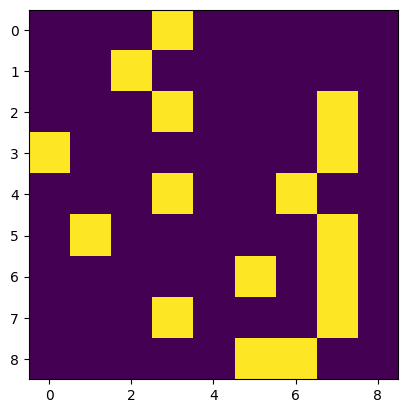

0            3.0
1            2.0
2            7.0
3            0.0
4            3.0
5            1.0
6            7.0
7            3.0
8            6.0
9            3.0
10           2.0
11           3.0
12           7.0
13           6.0
14           7.0
15           5.0
16           7.0
17           5.0
energy   -1536.0
Name: 71, dtype: float64


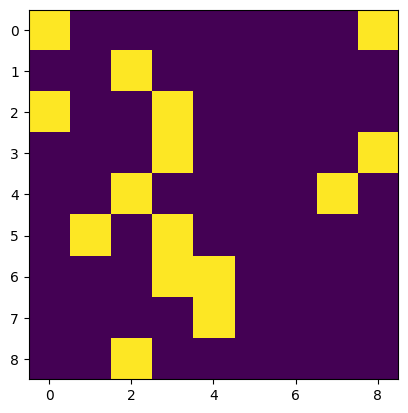

0            0.0
1            2.0
2            0.0
3            8.0
4            2.0
5            1.0
6            4.0
7            4.0
8            2.0
9            8.0
10           2.0
11           3.0
12           3.0
13           7.0
14           3.0
15           3.0
16           4.0
17           2.0
energy   -1536.0
Name: 72, dtype: float64


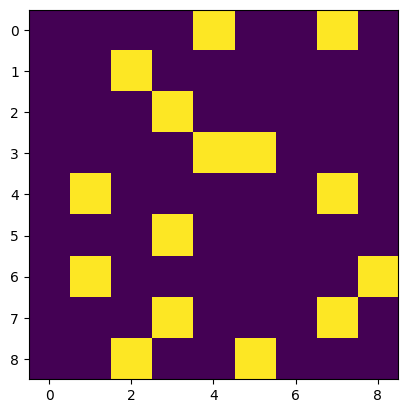

0            7.0
1            2.0
2            3.0
3            5.0
4            7.0
5            3.0
6            1.0
7            3.0
8            5.0
9            4.0
10           2.0
11           3.0
12           4.0
13           1.0
14           3.0
15           8.0
16           7.0
17           2.0
energy   -1536.0
Name: 73, dtype: float64


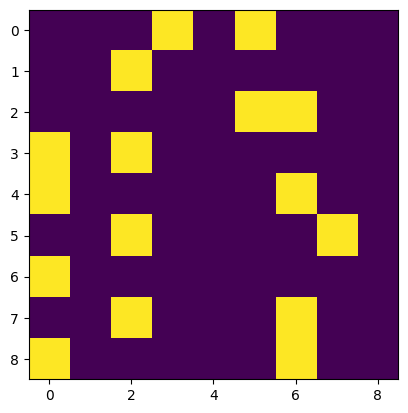

0            3.0
1            2.0
2            5.0
3            2.0
4            6.0
5            7.0
6            0.0
7            6.0
8            0.0
9            5.0
10           2.0
11           6.0
12           0.0
13           0.0
14           2.0
15           0.0
16           2.0
17           6.0
energy   -1536.0
Name: 74, dtype: float64


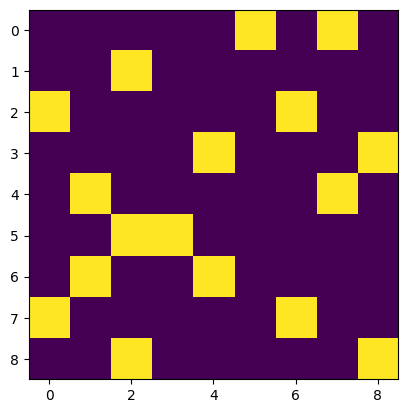

0            7.0
1            2.0
2            6.0
3            4.0
4            1.0
5            2.0
6            1.0
7            6.0
8            8.0
9            5.0
10           2.0
11           0.0
12           8.0
13           7.0
14           3.0
15           4.0
16           0.0
17           2.0
energy   -1536.0
Name: 75, dtype: float64


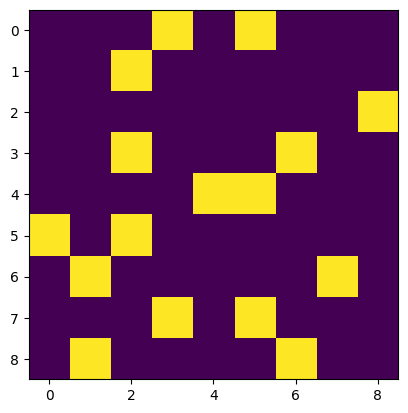

0            5.0
1            2.0
2            8.0
3            6.0
4            4.0
5            0.0
6            7.0
7            3.0
8            1.0
9            3.0
10           2.0
11           8.0
12           2.0
13           5.0
14           2.0
15           1.0
16           5.0
17           6.0
energy   -1536.0
Name: 76, dtype: float64


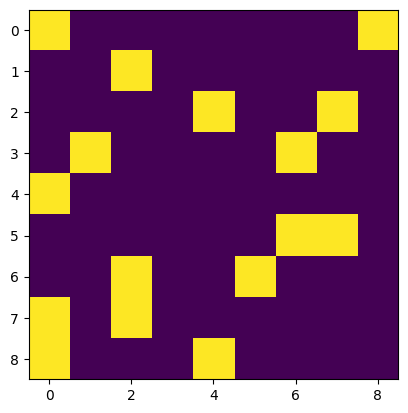

0            8.0
1            2.0
2            7.0
3            1.0
4            0.0
5            7.0
6            5.0
7            2.0
8            4.0
9            0.0
10           2.0
11           4.0
12           6.0
13           0.0
14           6.0
15           2.0
16           0.0
17           0.0
energy   -1536.0
Name: 77, dtype: float64


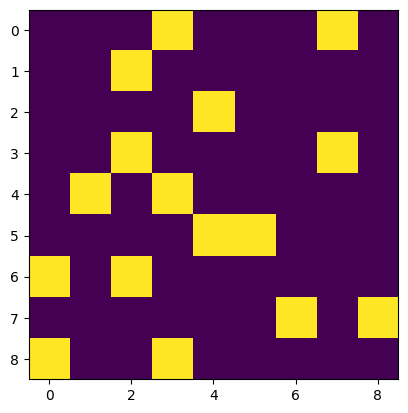

0            3.0
1            2.0
2            4.0
3            7.0
4            1.0
5            4.0
6            2.0
7            8.0
8            0.0
9            7.0
10           2.0
11           4.0
12           2.0
13           3.0
14           5.0
15           0.0
16           6.0
17           3.0
energy   -1536.0
Name: 78, dtype: float64


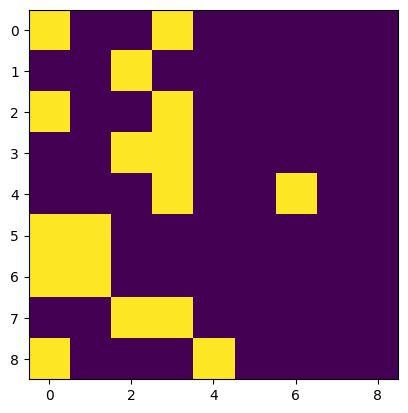

0            0.0
1            2.0
2            0.0
3            3.0
4            3.0
5            1.0
6            1.0
7            2.0
8            4.0
9            3.0
10           2.0
11           3.0
12           2.0
13           6.0
14           0.0
15           0.0
16           3.0
17           0.0
energy   -1536.0
Name: 79, dtype: float64


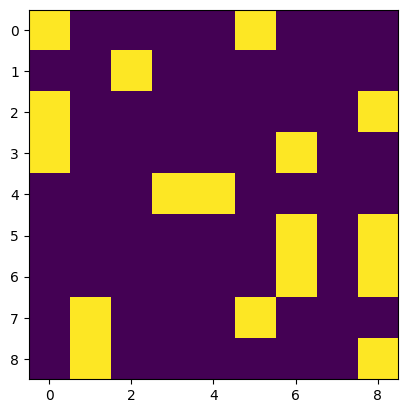

0            5.0
1            2.0
2            8.0
3            6.0
4            3.0
5            8.0
6            6.0
7            1.0
8            1.0
9            0.0
10           2.0
11           0.0
12           0.0
13           4.0
14           6.0
15           8.0
16           5.0
17           8.0
energy   -1536.0
Name: 80, dtype: float64


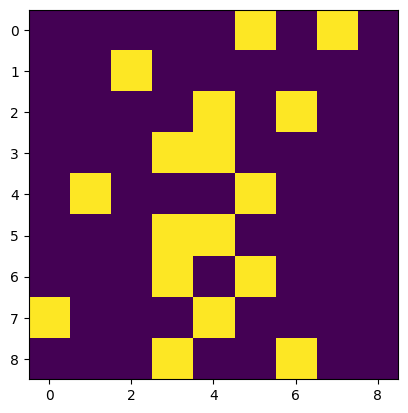

0            5.0
1            2.0
2            6.0
3            4.0
4            5.0
5            4.0
6            3.0
7            4.0
8            3.0
9            7.0
10           2.0
11           4.0
12           3.0
13           1.0
14           3.0
15           5.0
16           0.0
17           6.0
energy   -1536.0
Name: 81, dtype: float64


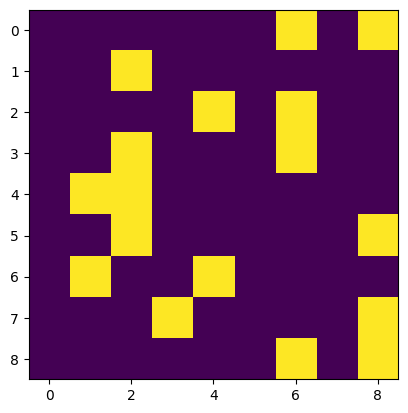

0            6.0
1            2.0
2            6.0
3            6.0
4            1.0
5            2.0
6            1.0
7            8.0
8            6.0
9            8.0
10           2.0
11           4.0
12           2.0
13           2.0
14           8.0
15           4.0
16           3.0
17           8.0
energy   -1536.0
Name: 82, dtype: float64


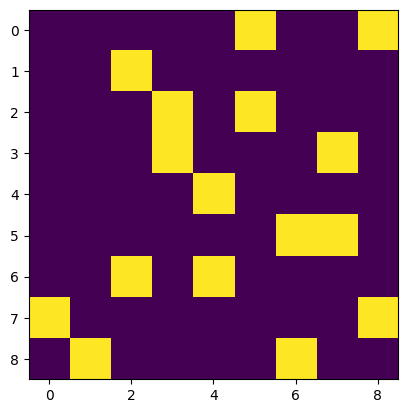

0            5.0
1            2.0
2            5.0
3            3.0
4            4.0
5            7.0
6            2.0
7            0.0
8            1.0
9            8.0
10           2.0
11           3.0
12           7.0
13           4.0
14           6.0
15           4.0
16           8.0
17           6.0
energy   -1536.0
Name: 83, dtype: float64


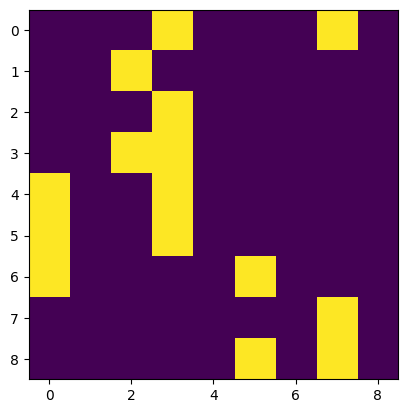

0            7.0
1            2.0
2            3.0
3            3.0
4            3.0
5            0.0
6            0.0
7            7.0
8            5.0
9            3.0
10           2.0
11           3.0
12           2.0
13           0.0
14           3.0
15           5.0
16           7.0
17           7.0
energy   -1536.0
Name: 84, dtype: float64


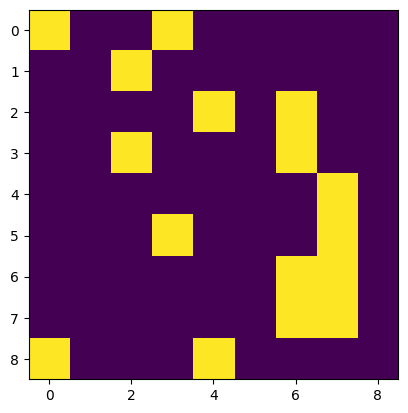

0            0.0
1            2.0
2            4.0
3            6.0
4            7.0
5            3.0
6            6.0
7            6.0
8            0.0
9            3.0
10           2.0
11           6.0
12           2.0
13           7.0
14           7.0
15           7.0
16           7.0
17           4.0
energy   -1536.0
Name: 85, dtype: float64


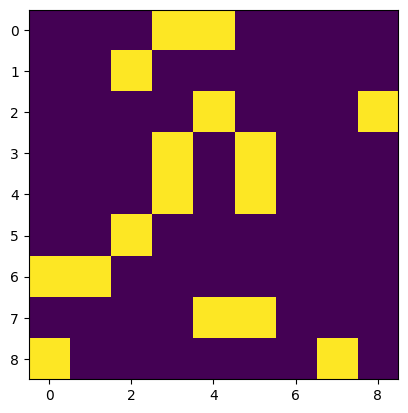

0            4.0
1            2.0
2            4.0
3            3.0
4            5.0
5            2.0
6            0.0
7            4.0
8            0.0
9            3.0
10           2.0
11           8.0
12           5.0
13           3.0
14           2.0
15           1.0
16           5.0
17           7.0
energy   -1536.0
Name: 86, dtype: float64


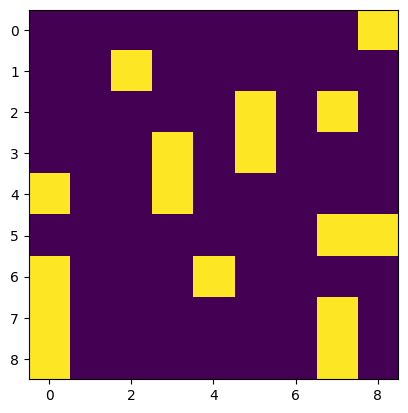

0            8.0
1            2.0
2            7.0
3            5.0
4            0.0
5            7.0
6            0.0
7            0.0
8            7.0
9            8.0
10           2.0
11           5.0
12           3.0
13           3.0
14           8.0
15           4.0
16           7.0
17           0.0
energy   -1536.0
Name: 87, dtype: float64


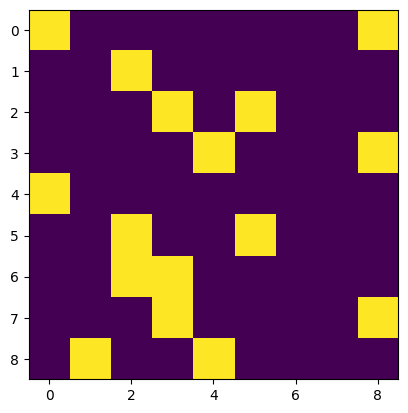

0            8.0
1            2.0
2            3.0
3            4.0
4            0.0
5            2.0
6            2.0
7            8.0
8            1.0
9            0.0
10           2.0
11           5.0
12           8.0
13           0.0
14           5.0
15           3.0
16           3.0
17           4.0
energy   -1536.0
Name: 88, dtype: float64


In [20]:
for i in range(df_NL.shape[0]):
    make_img_dis(np.array(df_NL.iloc[i,:2*n],dtype = 'int32'))
    print(df_NL.iloc[i,:2*n+1])

In [3]:
## SUM OVER TRIPLES

In [21]:
def line(point1,point2):
    # ax+by+c=0 from (p1-p)(p1-p2)'=0
    a=point2[1]-point1[1]; b=point1[0]-point2[0]; c=point1[1]*point2[0]-point1[0]*point2[1]
    f=math.gcd(a,b,c)
    f=1 if f==0 else -f if a<0 else f if a>0 else -f if b<0 else f
    return (a//f,b//f,c//f)

In [22]:
def get_linear_sets(n):
    #Get list of cart coords
    xs = range(n)
    ys = range(n)
    X = product(xs,ys)
    X = list(X)
    lines = []
    binary_sets = []
    line_set_dict = {}
    for k in range(len(X)):
        for d in range(k+1,len(X)):
            line_ = (line(X[k],X[d]))
            if line_ in lines:
                continue
            else:
                lines.append(line_)
                my_set = []
                my_set.append(X[k])
                my_set.append(X[d])
                x = X[d][0]
                y = X[d][1]
                dx = line_[1]
                dy = -line_[0]
                #print('(x,y)_1 = ', (x,y))
                if dx < 0:
                    dx = -dx
                    dy = -dy
                if dx == 0:
                    dy = abs(dy)
                #print('(dx,dy) = ', (dx,dy))
                x += dx
                y += dy
                #my_set.append((x,y)) 
                l = 1
                while 0 <= x < n and 0 <= y < n:
                    l += 1
                    my_set.append((x,y))
                    #print(f'(x,y)_{l} = ', (x,y))
                    
                    x += dx
                    y += dy
                    
                    
                #my_set = set(my_set)
                binary_sets.append(my_set)
                #print(line_, ':' ,my_set)
                line_set_dict.update({line_ : my_set})
    return line_set_dict

In [77]:
n=6
line_set_dictionary = get_linear_sets(n)
sets = list(line_set_dictionary.values())
bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY) #init BQM model

In [78]:
def get_interation_strengths(n):    
    X_tri_int = np.zeros((n**2,n**2,n**2),dtype = 'int32')
    for i in range(len(sets)):
        s = sets[i]
        if len(s) > 2:
            ind_set = [a for a in itertools.combinations([a for a in range(len(s))], 3)]
            #print(ind_set,s)
            for A in ind_set:
                x = s[A[0]][0]*n + s[A[0]][1] #x = in + j 
                y = s[A[1]][0]*n + s[A[1]][1]
                z = s[A[2]][0]*n + s[A[2]][1]
                #print('(x,y,z) = ' , (x,y,z))
                X_tri_int[x,y,z] += 1
    return X_tri_int
                

            

In [79]:
X_tri_int = get_interation_strengths(n)
X_tri_int[0,1,2]

1

In [80]:
#define binary decision vector.
x = [f's_{i}' for i in range(n**2)]
inter = [(f's_{i}',f's_{j}',f's_{k}') for (i,j,k) in itertools.combinations(range(n**2),3)]

In [81]:
int_dict = {}
for i in range(n**2):
    int_dict.update({(f's_{i}',f's_{i}') : -1})
    bqm.add_variable(f's_{i}',-1)
for (i,j,k) in itertools.combinations(range(n**2),3):
    if X_tri_int[i,j,k] != 0:
        int_dict.update({(f's_{i}',f's_{j}',f's_{k}') : X_tri_int[i,j,k]})
        bqm.update(dimod.make_quadratic({(f's_{i}',f's_{j}',f's_{k}') : X_tri_int[i,j,k]},strength = 1,vartype = dimod.BINARY))

In [82]:
from hybrid.reference import KerberosSampler

solution = KerberosSampler().sample(bqm,
                                    max_iter=10,
                                    convergence=3,
                                    qpu_params={'label': 'Example - latin square'})
best_sol = solution.first.sample
solution_list = [k for k, v in best_sol.items() if v == 1]

In [83]:
solution_list

['s_16',
 's_16*s_17',
 's_16*s_3',
 's_17',
 's_18',
 's_18*s_3',
 's_18*s_30',
 's_18*s_32',
 's_19',
 's_26',
 's_26*s_16',
 's_28',
 's_28*s_16',
 's_28*s_26',
 's_28*s_7',
 's_3',
 's_30',
 's_30*s_19',
 's_30*s_5',
 's_32',
 's_32*s_17',
 's_32*s_26',
 's_5',
 's_7',
 's_7*s_19',
 's_7*s_9',
 's_9',
 's_9*s_16',
 's_9*s_19']

In [84]:
import dimod
hubo = int_dict

In [85]:
A = dimod.ExactPolySolver().sample_poly(dimod.BinaryPolynomial(hubo, 'BINARY')).to_pandas_dataframe()
A

In [ ]:
A

In [ ]:
df = dimod.ExactPolySolver().sample_hubo(hubo).to_pandas_dataframe()

In [ ]:
df['energy'].unique()

In [ ]:
df

In [ ]:
df.sort_values(by = 'energy')

In [ ]:
df.iloc[df[['energy']].idxmin()[0],:]

In [ ]:
def sample_to_img(df):
    num = df[['energy']].idxmin()[0]
    bit_string = np.zeros(n**2)
    for i in range(df.shape[1]-2):
        if df.iloc[num][f's_{i}'] == 1:
            bit_string[i] = 1
    make_img_bit_string(bit_string)
sample_to_img(df)

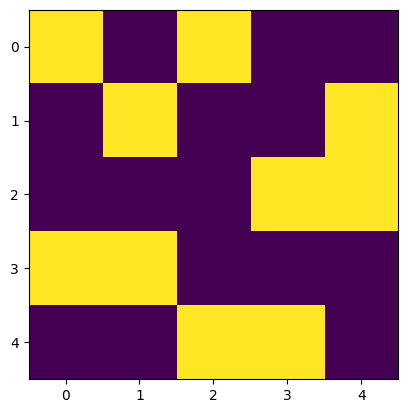

[1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 0.]


In [19]:
def sample_to_img(df):
    num = df[['energy']].idxmin()[0]
    bit_string = np.zeros(n**2)
    for i in range(df.shape[1]-2):
        if df.iloc[num][f's_{i}'] == 1:
            bit_string[i] = 1
    make_img_bit_string(bit_string)
sample_to_img(df)